In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 8.6 MB/s eta 0:00:00


In [3]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.5 MB/s eta 0:00:00


In [31]:
from ultralytics import YOLO
from IPython.display import Image
import os
import cv2
import easyocr
import pandas as pd
import numpy as np
import ast
import shutil
import csv
import string
import matplotlib.pyplot as plt
from copy import deepcopy

In [11]:
path_directory = '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8'

## **Train Model: YOLO v8**

In [ ]:
# Specify the path you want to count files in
path = '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/data/images/train'

# List all files in the specified path
files = os.listdir(path)

# Get the number of files in the path
num_files = len(files)

# Print the number of files
print(f"Number of files in the path: {num_files}")


In [ ]:
#Load model
model = YOLO('yolov8s.pt')

#Train the model
model.train(data=os.path.join(path_directory, "data.yaml"), epochs=100)

In [ ]:
import shutil

# Copy the runs directory to Google Drive
shutil.copytree('/content/runs', '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs')

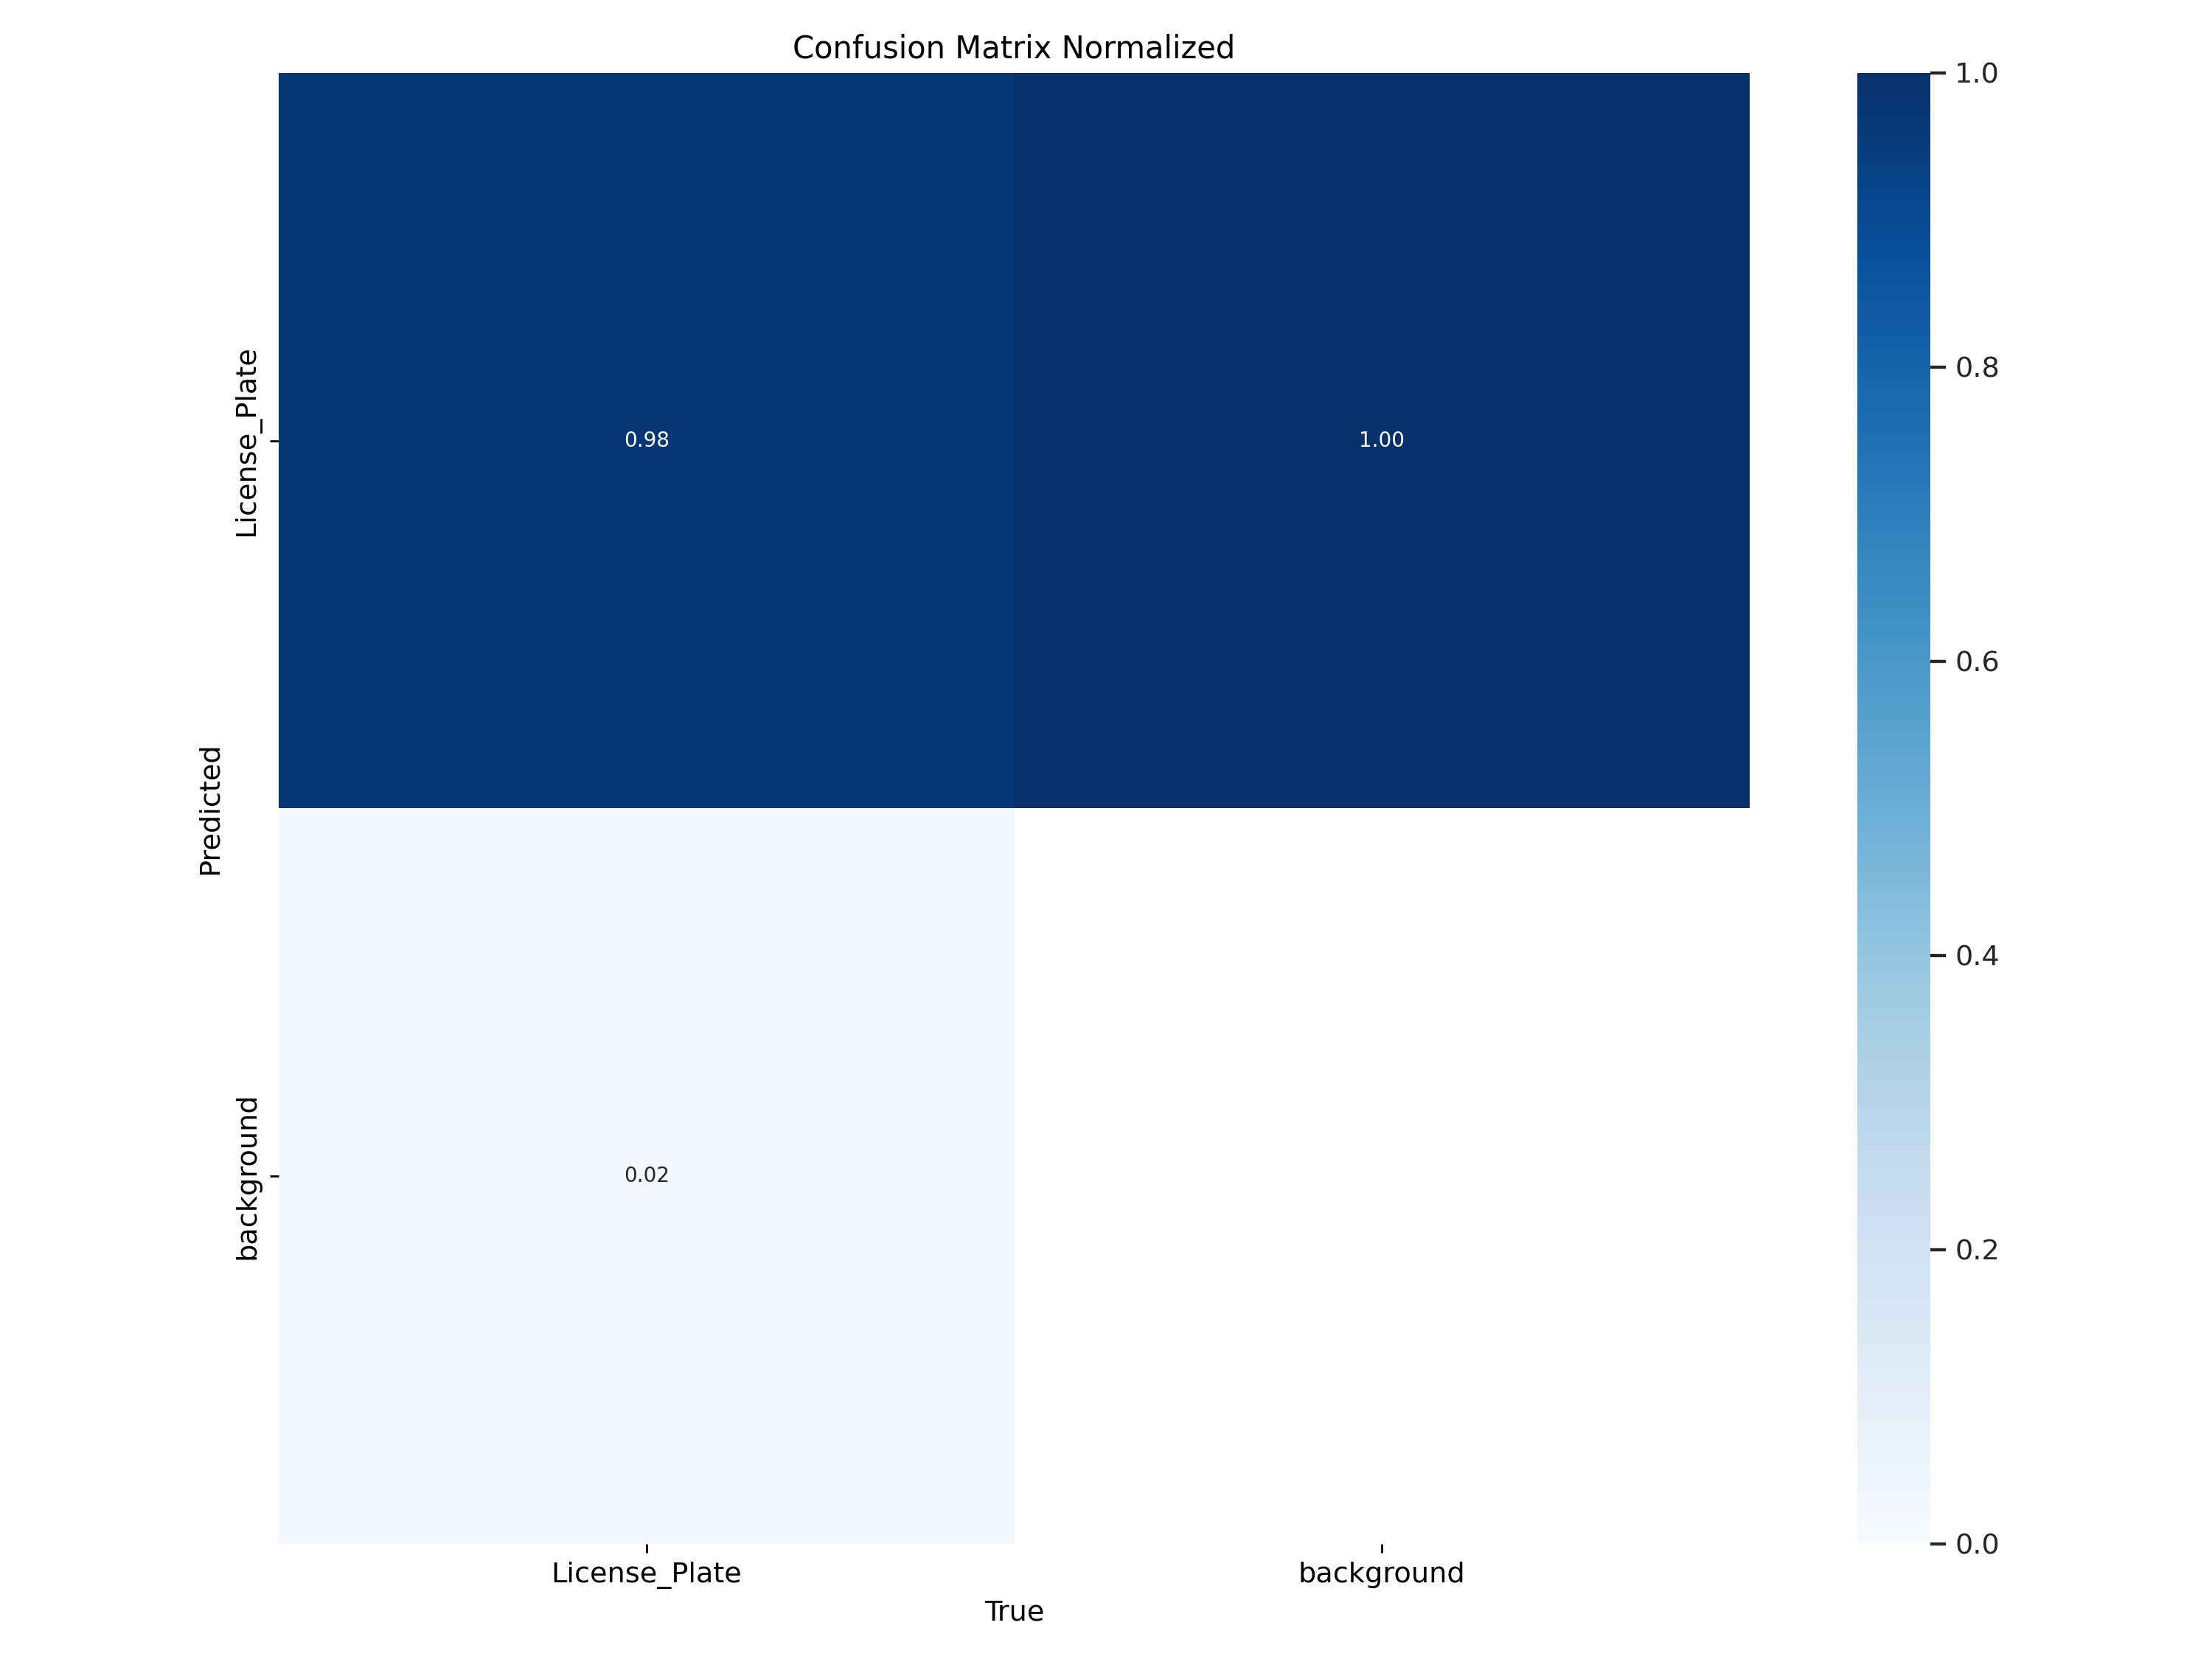

In [135]:
Image(filename = '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/confusion_matrix_normalized.png', width=1000)

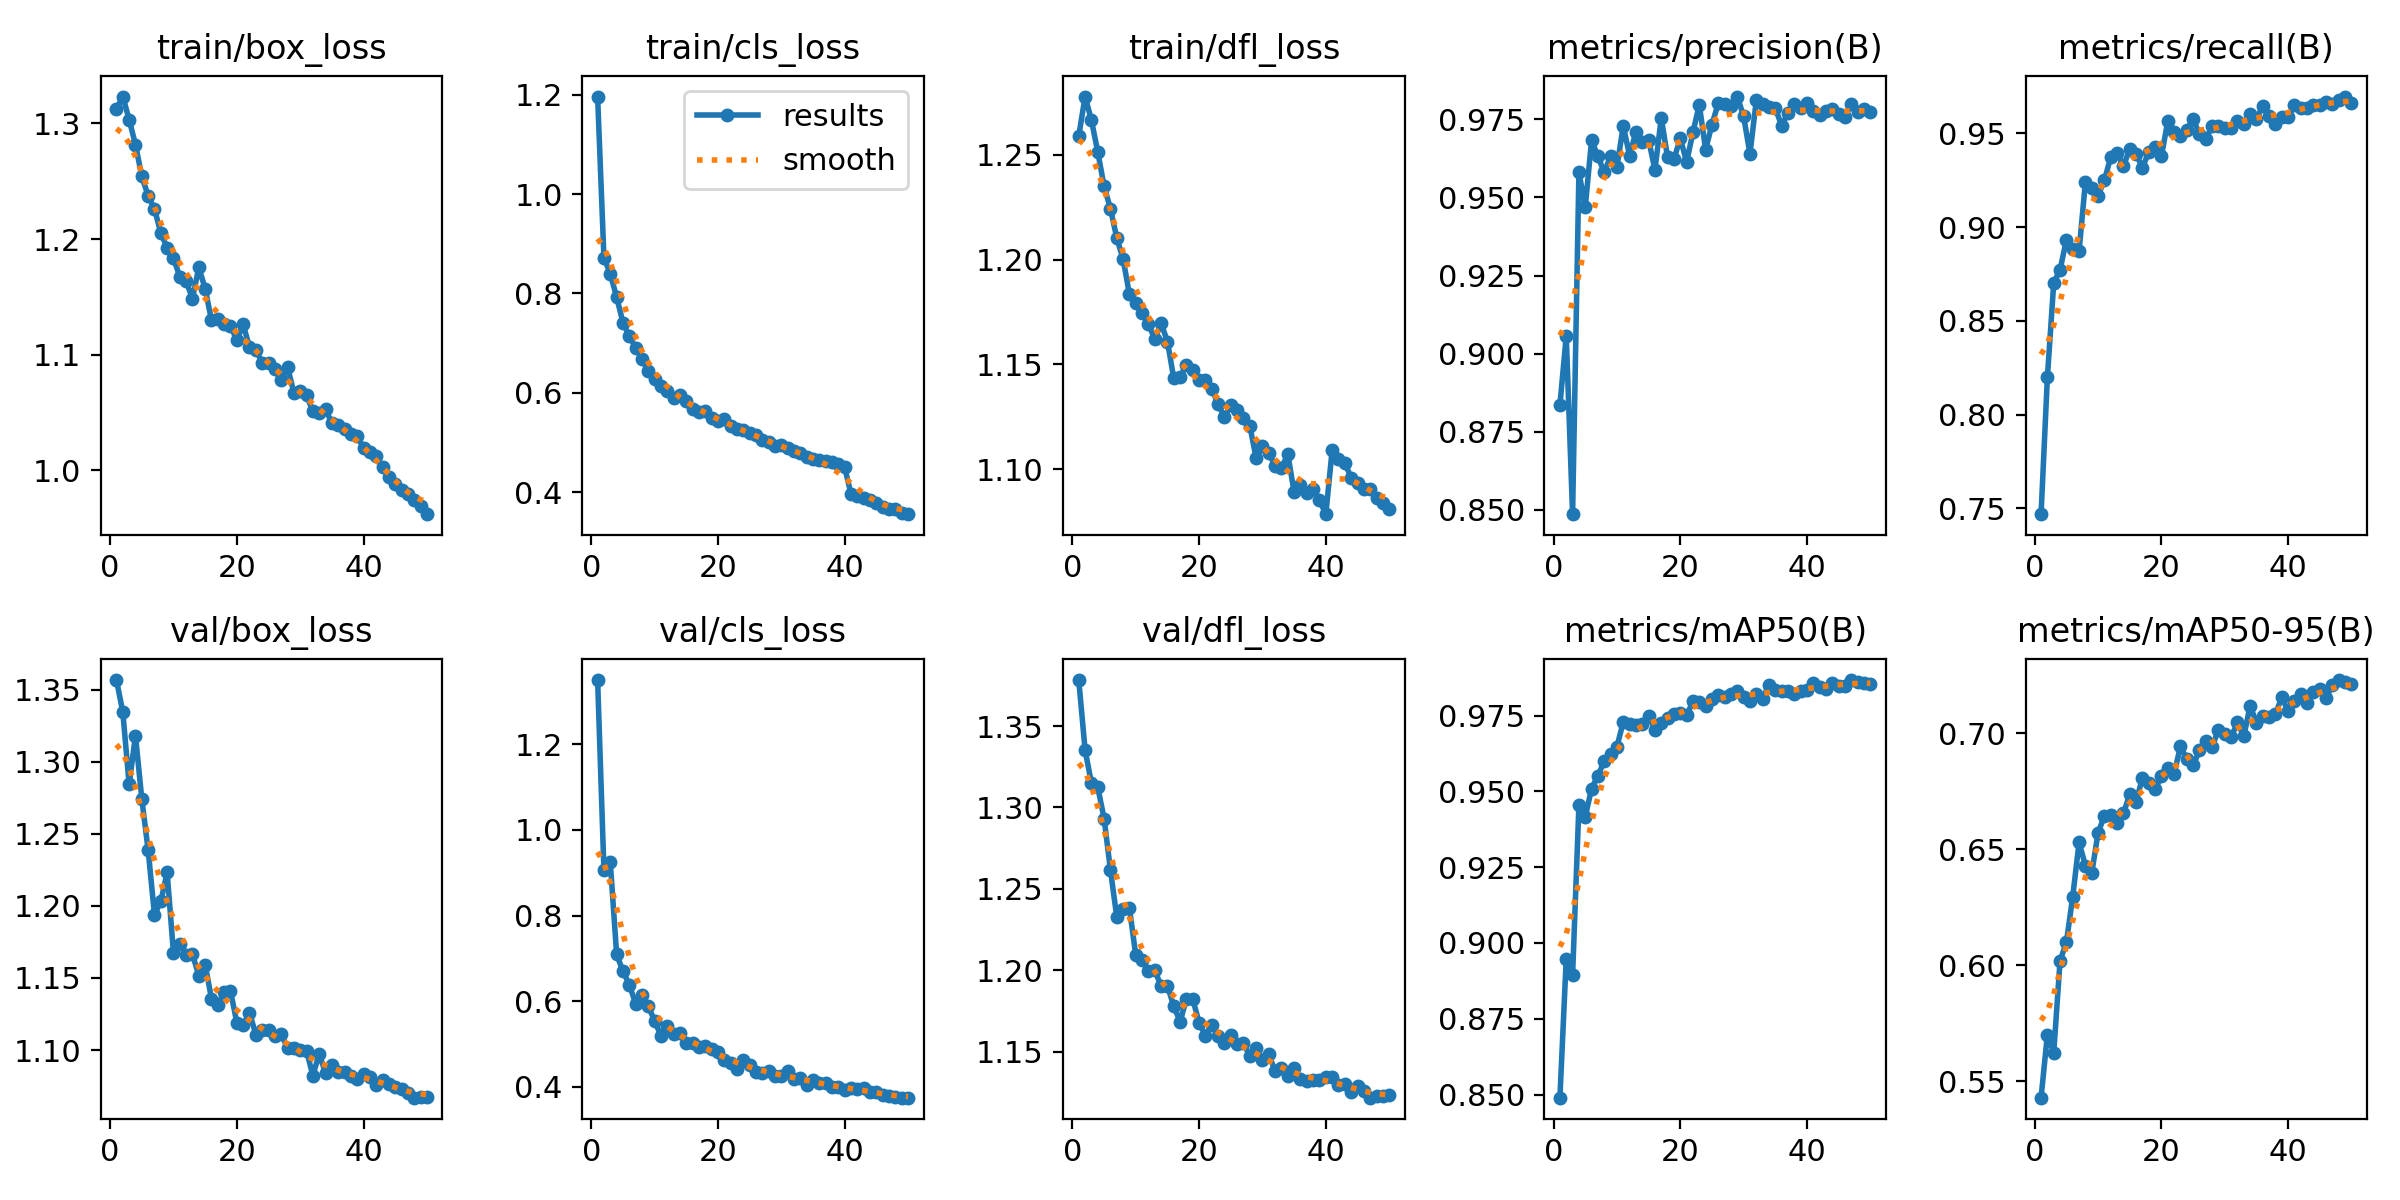

In [136]:
Image(filename = '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/results.png', width=1200)

## **Validation**

In [14]:
best_model = '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/weights/best.pt'
data = os.path.join(path_directory, "data.yaml")

In [16]:
print(data)

/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/data.yaml


In [17]:
!yolo task=detect mode=val model='/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/weights/best.pt' data='/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/data.yaml'

Ultralytics YOLOv8.0.200 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
100% 755k/755k [00:00<00:00, 40.3MB/s]
val: Scanning /content/drive/.shortcut-targets-by-id/17PFyNbZl199xaa-1fHf8IyjnCSBGOk3q/ComputerVision/Vehicle_License_PlateYOLOv8/data/labels/valid.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% 2048/2048 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [34:04<00:00, 15.97s/it]
                   all       2048       2134      0.977      0.968      0.986      0.723
Speed: 7.5ms preprocess, 953.6ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val4
💡 Learn more at https://docs.ultralytics.com/modes/val


In [69]:
shutil.copytree('/content/runs', '/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/val')

'/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/val'

## **License Plate Detector**

For this case, we are going to focus on specific vehicle plate number which consist of 6 characters, where:

*   the first character is alphabets
*   the next three characters are numbers
*   the last two characters are alphabets

Example: L 656 XH

To fulfill this format, we make a defined function to match the format.

In [165]:
# Mapping dictionaries for character conversion
dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5'}

dict_int_to_char = {'0': 'O',
                    '1': 'I',
                    '3': 'J',
                    '4': 'A',
                    '6': 'G',
                    '5': 'S'}

#Ceck if the license plate text matches with the required format
def license_complies_format(text):
  if len(text) != 6:
    return False

  if (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys()) and \
     (text[1] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[1] in dict_char_to_int.keys()) and \
     (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[2] in dict_char_to_int.keys()) and \
     (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[3] in dict_char_to_int.keys()) and \
     (text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()) and \
     (text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()):
     return True
  else:
    return False

#Fix the license plate text by changing characters using the mapping dictionaries
def format_license(text):
    license_plate_ = ''
    mapping = {0: dict_int_to_char, 1: dict_int_to_char, 4: dict_int_to_char, 5: dict_int_to_char, 6: dict_int_to_char,
               2: dict_char_to_int, 3: dict_char_to_int}
    for j in [0, 1, 2, 3, 4, 5]:
        if text[j] in mapping[j].keys():
            license_plate_ += mapping[j][text[j]]
        else:
            license_plate_ += text[j]

    return license_plate_

#read license number
reader = easyocr.Reader(['en'], gpu = False)

def read_license_number(license_plate):
    detections = reader.readtext(license_plate)
    detected_text = ""
    text_score = 0

    for detection in detections:
        bbox, text, current_text_score = detection

        # Remove non-alphanumeric characters and convert to uppercase
        cleaned_text = ''.join(char.upper() for char in text if char.isalnum())

        detected_text = cleaned_text
        text_score = current_text_score

    return detected_text, text_score

Here we apply license plate object detection and license plate numbers recognition using YOLOv8 and EasyOCR to this [video](https://drive.google.com/uc?id=1P-oVR0J35Dw40lzw47sE19oADSW-tyb1&confirm=t), obtained from [Muhammad Moin's repository](https://github.com/MuhammadMoinFaisal/Automatic_Number_Plate_Detection_Recognition_YOLOv8/tree/main)

In [159]:
model = YOLO('/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/weights/best.pt')
video = cv2.VideoCapture('/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/video.mp4')

frame_number = -1
results = {}
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
cond = True

# Output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter('/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/prediction/result_video.mp4', fourcc, 20.0, (int(video.get(3)), int(video.get(4))))

while cond:
    frame_number += 1
    cond, frame = video.read()

    if not cond:
        break  # No more frames to read, exit the loop

    # Detect license plates
    license_plates = model(frame)[0]
    detections_ = []

    for detection in license_plates.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection

        # Crop license plate
        license_plate_crop = frame[int(y1):int(y2), int(x1):int(x2), :]

        # Pre-processing license plate
        license_plate_gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
        _, license_plate_binary = cv2.threshold(license_plate_gray, 100, 255, cv2.THRESH_BINARY_INV)

        # Read license plate number
        license_plate_text, license_plate_score = read_license_number(license_plate_binary)

        if license_plate_text is not None:
            results[frame_number] = {
                'license_plate': {
                    'bbox': [x1, y1, x2, y2],  # Coordinate bbox
                    'license_plate_text': license_plate_text,
                    'bbox_score': score,  # Score bbox
                    'text_score': license_plate_score
                }
            }

            # Draw the license plate and text on the frame
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 3)  # Yellow bounding box, thickness=3
            text_position = (int(x1), int(y1) - 15)
            cv2.putText(frame, license_plate_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3)  # Yellow text, font size=1.5

    print(f'Processed frame {frame_number} of {total_frames}')
    # Write the frame with license plate info to the output video
    output_video.write(frame)

video.release()
output_video.release()

print(f'Processing completed. Result video saved.')



0: 416x640 2 License_Plates, 689.6ms
Speed: 4.2ms preprocess, 689.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 0 of 631


0: 416x640 2 License_Plates, 411.4ms
Speed: 5.7ms preprocess, 411.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 1 of 631


0: 416x640 2 License_Plates, 406.6ms
Speed: 4.7ms preprocess, 406.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 2 of 631


0: 416x640 2 License_Plates, 395.8ms
Speed: 3.0ms preprocess, 395.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 3 of 631


0: 416x640 2 License_Plates, 393.1ms
Speed: 5.6ms preprocess, 393.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 4 of 631


0: 416x640 2 License_Plates, 655.9ms
Speed: 3.9ms preprocess, 655.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 5 of 631


0: 416x640 2 License_Plates, 657.4ms
Speed: 4.2ms preprocess, 657.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 6 of 631


0: 416x640 2 License_Plates, 660.4ms
Speed: 4.1ms preprocess, 660.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 7 of 631


0: 416x640 2 License_Plates, 673.6ms
Speed: 4.0ms preprocess, 673.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 8 of 631


0: 416x640 2 License_Plates, 560.2ms
Speed: 4.0ms preprocess, 560.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 9 of 631


0: 416x640 2 License_Plates, 400.4ms
Speed: 4.7ms preprocess, 400.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 10 of 631


0: 416x640 1 License_Plate, 401.2ms
Speed: 3.9ms preprocess, 401.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 11 of 631


0: 416x640 2 License_Plates, 407.3ms
Speed: 4.3ms preprocess, 407.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 12 of 631


0: 416x640 2 License_Plates, 409.2ms
Speed: 4.7ms preprocess, 409.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 13 of 631


0: 416x640 1 License_Plate, 393.8ms
Speed: 4.0ms preprocess, 393.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 14 of 631


0: 416x640 1 License_Plate, 390.6ms
Speed: 5.1ms preprocess, 390.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 15 of 631


0: 416x640 2 License_Plates, 402.5ms
Speed: 5.4ms preprocess, 402.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 16 of 631


0: 416x640 1 License_Plate, 397.8ms
Speed: 3.8ms preprocess, 397.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 17 of 631


0: 416x640 1 License_Plate, 397.1ms
Speed: 6.0ms preprocess, 397.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 18 of 631


0: 416x640 1 License_Plate, 401.6ms
Speed: 3.9ms preprocess, 401.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 19 of 631


0: 416x640 1 License_Plate, 397.7ms
Speed: 4.0ms preprocess, 397.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 20 of 631


0: 416x640 1 License_Plate, 399.4ms
Speed: 4.3ms preprocess, 399.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 21 of 631


0: 416x640 1 License_Plate, 410.3ms
Speed: 4.0ms preprocess, 410.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 22 of 631


0: 416x640 1 License_Plate, 390.1ms
Speed: 4.3ms preprocess, 390.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 23 of 631


0: 416x640 1 License_Plate, 662.1ms
Speed: 4.0ms preprocess, 662.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 24 of 631


0: 416x640 1 License_Plate, 678.9ms
Speed: 3.9ms preprocess, 678.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 25 of 631


0: 416x640 1 License_Plate, 669.7ms
Speed: 4.0ms preprocess, 669.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 26 of 631


0: 416x640 1 License_Plate, 655.6ms
Speed: 4.0ms preprocess, 655.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 27 of 631


0: 416x640 1 License_Plate, 628.0ms
Speed: 5.7ms preprocess, 628.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 28 of 631


0: 416x640 1 License_Plate, 392.3ms
Speed: 3.2ms preprocess, 392.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 29 of 631


0: 416x640 1 License_Plate, 394.6ms
Speed: 4.7ms preprocess, 394.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 30 of 631


0: 416x640 1 License_Plate, 464.7ms
Speed: 4.9ms preprocess, 464.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 31 of 631


0: 416x640 1 License_Plate, 395.9ms
Speed: 4.0ms preprocess, 395.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 32 of 631


0: 416x640 1 License_Plate, 393.7ms
Speed: 4.1ms preprocess, 393.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 33 of 631


0: 416x640 1 License_Plate, 404.8ms
Speed: 6.3ms preprocess, 404.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 34 of 631


0: 416x640 1 License_Plate, 403.9ms
Speed: 3.8ms preprocess, 403.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 35 of 631


0: 416x640 1 License_Plate, 390.0ms
Speed: 4.8ms preprocess, 390.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 36 of 631


0: 416x640 1 License_Plate, 398.8ms
Speed: 6.3ms preprocess, 398.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 37 of 631


0: 416x640 1 License_Plate, 388.6ms
Speed: 5.1ms preprocess, 388.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 38 of 631


0: 416x640 1 License_Plate, 392.1ms
Speed: 3.7ms preprocess, 392.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 39 of 631


0: 416x640 1 License_Plate, 401.0ms
Speed: 4.1ms preprocess, 401.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 40 of 631


0: 416x640 1 License_Plate, 406.3ms
Speed: 3.8ms preprocess, 406.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 41 of 631


0: 416x640 1 License_Plate, 409.9ms
Speed: 3.5ms preprocess, 409.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 42 of 631


0: 416x640 1 License_Plate, 437.8ms
Speed: 5.1ms preprocess, 437.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 43 of 631


0: 416x640 1 License_Plate, 653.3ms
Speed: 4.3ms preprocess, 653.3ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 44 of 631


0: 416x640 1 License_Plate, 662.8ms
Speed: 3.9ms preprocess, 662.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 45 of 631


0: 416x640 1 License_Plate, 656.9ms
Speed: 4.2ms preprocess, 656.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 46 of 631


0: 416x640 1 License_Plate, 655.6ms
Speed: 4.0ms preprocess, 655.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 47 of 631


0: 416x640 1 License_Plate, 636.9ms
Speed: 4.9ms preprocess, 636.9ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 48 of 631


0: 416x640 1 License_Plate, 408.0ms
Speed: 6.4ms preprocess, 408.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 49 of 631


0: 416x640 1 License_Plate, 410.5ms
Speed: 4.6ms preprocess, 410.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 50 of 631


0: 416x640 1 License_Plate, 398.7ms
Speed: 3.8ms preprocess, 398.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 51 of 631


0: 416x640 1 License_Plate, 400.2ms
Speed: 4.7ms preprocess, 400.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 52 of 631


0: 416x640 1 License_Plate, 407.4ms
Speed: 3.8ms preprocess, 407.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 53 of 631


0: 416x640 1 License_Plate, 389.8ms
Speed: 5.8ms preprocess, 389.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 54 of 631


0: 416x640 1 License_Plate, 400.2ms
Speed: 4.5ms preprocess, 400.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 55 of 631


0: 416x640 1 License_Plate, 406.7ms
Speed: 4.0ms preprocess, 406.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 56 of 631


0: 416x640 1 License_Plate, 392.7ms
Speed: 3.9ms preprocess, 392.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 57 of 631


0: 416x640 1 License_Plate, 403.1ms
Speed: 3.9ms preprocess, 403.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 58 of 631


0: 416x640 1 License_Plate, 393.3ms
Speed: 4.8ms preprocess, 393.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 59 of 631


0: 416x640 1 License_Plate, 394.8ms
Speed: 3.6ms preprocess, 394.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 60 of 631


0: 416x640 1 License_Plate, 413.7ms
Speed: 5.0ms preprocess, 413.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 61 of 631


0: 416x640 1 License_Plate, 391.7ms
Speed: 6.0ms preprocess, 391.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 62 of 631


0: 416x640 1 License_Plate, 391.2ms
Speed: 4.9ms preprocess, 391.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 63 of 631


0: 416x640 1 License_Plate, 554.6ms
Speed: 5.8ms preprocess, 554.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 64 of 631


0: 416x640 1 License_Plate, 657.5ms
Speed: 4.1ms preprocess, 657.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 65 of 631


0: 416x640 1 License_Plate, 657.5ms
Speed: 3.8ms preprocess, 657.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 66 of 631


0: 416x640 1 License_Plate, 673.5ms
Speed: 6.6ms preprocess, 673.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 67 of 631


0: 416x640 1 License_Plate, 658.4ms
Speed: 4.7ms preprocess, 658.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 68 of 631


0: 416x640 1 License_Plate, 1150.7ms
Speed: 4.7ms preprocess, 1150.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 69 of 631


0: 416x640 1 License_Plate, 423.7ms
Speed: 4.8ms preprocess, 423.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 70 of 631


0: 416x640 1 License_Plate, 407.4ms
Speed: 3.2ms preprocess, 407.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 71 of 631


0: 416x640 1 License_Plate, 402.1ms
Speed: 3.9ms preprocess, 402.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 72 of 631


0: 416x640 1 License_Plate, 489.3ms
Speed: 3.8ms preprocess, 489.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 73 of 631


0: 416x640 1 License_Plate, 402.8ms
Speed: 6.0ms preprocess, 402.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 74 of 631


0: 416x640 1 License_Plate, 406.6ms
Speed: 4.0ms preprocess, 406.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 75 of 631


0: 416x640 1 License_Plate, 396.3ms
Speed: 3.6ms preprocess, 396.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 76 of 631


0: 416x640 1 License_Plate, 406.1ms
Speed: 3.8ms preprocess, 406.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 77 of 631


0: 416x640 1 License_Plate, 407.7ms
Speed: 5.4ms preprocess, 407.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 78 of 631


0: 416x640 1 License_Plate, 402.8ms
Speed: 3.5ms preprocess, 402.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 79 of 631


0: 416x640 1 License_Plate, 405.2ms
Speed: 4.4ms preprocess, 405.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 80 of 631


0: 416x640 1 License_Plate, 395.4ms
Speed: 5.4ms preprocess, 395.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 81 of 631


0: 416x640 1 License_Plate, 409.9ms
Speed: 3.9ms preprocess, 409.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 82 of 631


0: 416x640 1 License_Plate, 400.1ms
Speed: 5.0ms preprocess, 400.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 83 of 631


0: 416x640 1 License_Plate, 438.2ms
Speed: 6.0ms preprocess, 438.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 84 of 631


0: 416x640 1 License_Plate, 686.9ms
Speed: 4.9ms preprocess, 686.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 85 of 631


0: 416x640 1 License_Plate, 665.0ms
Speed: 8.2ms preprocess, 665.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 86 of 631


0: 416x640 1 License_Plate, 673.0ms
Speed: 4.0ms preprocess, 673.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 87 of 631


0: 416x640 1 License_Plate, 668.9ms
Speed: 4.0ms preprocess, 668.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 88 of 631


0: 416x640 1 License_Plate, 636.7ms
Speed: 4.7ms preprocess, 636.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 89 of 631


0: 416x640 1 License_Plate, 482.5ms
Speed: 4.1ms preprocess, 482.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 90 of 631


0: 416x640 1 License_Plate, 397.1ms
Speed: 3.6ms preprocess, 397.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 91 of 631


0: 416x640 1 License_Plate, 397.8ms
Speed: 6.0ms preprocess, 397.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 92 of 631


0: 416x640 1 License_Plate, 397.8ms
Speed: 6.1ms preprocess, 397.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 93 of 631


0: 416x640 1 License_Plate, 418.7ms
Speed: 3.8ms preprocess, 418.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 94 of 631


0: 416x640 1 License_Plate, 397.8ms
Speed: 5.0ms preprocess, 397.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 95 of 631


0: 416x640 1 License_Plate, 397.3ms
Speed: 3.9ms preprocess, 397.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 96 of 631


0: 416x640 1 License_Plate, 407.9ms
Speed: 4.6ms preprocess, 407.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 97 of 631


0: 416x640 2 License_Plates, 403.4ms
Speed: 4.8ms preprocess, 403.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 98 of 631


0: 416x640 1 License_Plate, 402.6ms
Speed: 4.5ms preprocess, 402.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 99 of 631


0: 416x640 2 License_Plates, 406.4ms
Speed: 6.0ms preprocess, 406.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 100 of 631


0: 416x640 1 License_Plate, 391.8ms
Speed: 5.1ms preprocess, 391.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 101 of 631


0: 416x640 1 License_Plate, 407.7ms
Speed: 4.0ms preprocess, 407.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 102 of 631


0: 416x640 2 License_Plates, 420.3ms
Speed: 4.2ms preprocess, 420.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 103 of 631


0: 416x640 2 License_Plates, 399.5ms
Speed: 4.3ms preprocess, 399.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 104 of 631


0: 416x640 2 License_Plates, 537.5ms
Speed: 3.9ms preprocess, 537.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 105 of 631


0: 416x640 2 License_Plates, 649.0ms
Speed: 4.0ms preprocess, 649.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 106 of 631


0: 416x640 2 License_Plates, 659.8ms
Speed: 4.1ms preprocess, 659.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 107 of 631


0: 416x640 1 License_Plate, 649.3ms
Speed: 4.3ms preprocess, 649.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 108 of 631


0: 416x640 1 License_Plate, 657.2ms
Speed: 5.7ms preprocess, 657.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 109 of 631


0: 416x640 1 License_Plate, 702.5ms
Speed: 5.5ms preprocess, 702.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 110 of 631


0: 416x640 2 License_Plates, 396.9ms
Speed: 4.2ms preprocess, 396.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 111 of 631


0: 416x640 1 License_Plate, 424.6ms
Speed: 5.5ms preprocess, 424.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 112 of 631


0: 416x640 1 License_Plate, 413.3ms
Speed: 4.3ms preprocess, 413.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 113 of 631


0: 416x640 1 License_Plate, 401.5ms
Speed: 4.1ms preprocess, 401.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 114 of 631


0: 416x640 1 License_Plate, 400.9ms
Speed: 3.8ms preprocess, 400.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 115 of 631


0: 416x640 2 License_Plates, 669.8ms
Speed: 3.7ms preprocess, 669.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 116 of 631


0: 416x640 1 License_Plate, 398.1ms
Speed: 5.2ms preprocess, 398.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 117 of 631


0: 416x640 2 License_Plates, 400.7ms
Speed: 8.0ms preprocess, 400.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 118 of 631


0: 416x640 1 License_Plate, 406.5ms
Speed: 4.6ms preprocess, 406.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 119 of 631


0: 416x640 2 License_Plates, 400.2ms
Speed: 6.1ms preprocess, 400.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 120 of 631


0: 416x640 2 License_Plates, 395.6ms
Speed: 3.9ms preprocess, 395.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 121 of 631


0: 416x640 1 License_Plate, 407.9ms
Speed: 4.2ms preprocess, 407.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 122 of 631


0: 416x640 1 License_Plate, 651.4ms
Speed: 4.1ms preprocess, 651.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 123 of 631


0: 416x640 1 License_Plate, 685.8ms
Speed: 4.0ms preprocess, 685.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 124 of 631


0: 416x640 1 License_Plate, 670.7ms
Speed: 4.1ms preprocess, 670.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 125 of 631


0: 416x640 1 License_Plate, 657.9ms
Speed: 4.0ms preprocess, 657.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 126 of 631


0: 416x640 2 License_Plates, 633.1ms
Speed: 4.7ms preprocess, 633.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 127 of 631


0: 416x640 2 License_Plates, 396.2ms
Speed: 4.3ms preprocess, 396.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 128 of 631


0: 416x640 2 License_Plates, 407.8ms
Speed: 4.3ms preprocess, 407.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 129 of 631


0: 416x640 1 License_Plate, 409.1ms
Speed: 3.8ms preprocess, 409.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 130 of 631


0: 416x640 1 License_Plate, 395.2ms
Speed: 3.0ms preprocess, 395.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 131 of 631


0: 416x640 1 License_Plate, 415.6ms
Speed: 4.2ms preprocess, 415.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 132 of 631


0: 416x640 1 License_Plate, 402.8ms
Speed: 3.9ms preprocess, 402.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 133 of 631


0: 416x640 2 License_Plates, 393.8ms
Speed: 5.7ms preprocess, 393.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 134 of 631


0: 416x640 3 License_Plates, 414.2ms
Speed: 6.5ms preprocess, 414.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 135 of 631


0: 416x640 2 License_Plates, 410.8ms
Speed: 4.0ms preprocess, 410.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 136 of 631


0: 416x640 1 License_Plate, 399.9ms
Speed: 3.9ms preprocess, 399.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 137 of 631


0: 416x640 2 License_Plates, 404.6ms
Speed: 4.4ms preprocess, 404.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 138 of 631


0: 416x640 1 License_Plate, 416.6ms
Speed: 3.9ms preprocess, 416.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 139 of 631


0: 416x640 2 License_Plates, 403.3ms
Speed: 6.4ms preprocess, 403.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 140 of 631


0: 416x640 2 License_Plates, 393.2ms
Speed: 4.0ms preprocess, 393.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 141 of 631


0: 416x640 2 License_Plates, 660.1ms
Speed: 5.6ms preprocess, 660.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 142 of 631


0: 416x640 2 License_Plates, 662.9ms
Speed: 4.1ms preprocess, 662.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 143 of 631


0: 416x640 2 License_Plates, 680.8ms
Speed: 4.0ms preprocess, 680.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 144 of 631


0: 416x640 1 License_Plate, 661.1ms
Speed: 4.1ms preprocess, 661.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 145 of 631


0: 416x640 2 License_Plates, 546.3ms
Speed: 4.4ms preprocess, 546.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 146 of 631


0: 416x640 1 License_Plate, 402.7ms
Speed: 4.6ms preprocess, 402.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 147 of 631


0: 416x640 1 License_Plate, 396.3ms
Speed: 5.1ms preprocess, 396.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 148 of 631


0: 416x640 1 License_Plate, 413.1ms
Speed: 3.8ms preprocess, 413.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 149 of 631


0: 416x640 1 License_Plate, 416.7ms
Speed: 4.2ms preprocess, 416.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 150 of 631


0: 416x640 1 License_Plate, 403.0ms
Speed: 5.3ms preprocess, 403.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 151 of 631


0: 416x640 1 License_Plate, 395.5ms
Speed: 6.0ms preprocess, 395.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 152 of 631


0: 416x640 1 License_Plate, 423.8ms
Speed: 4.9ms preprocess, 423.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 153 of 631


0: 416x640 1 License_Plate, 409.2ms
Speed: 4.4ms preprocess, 409.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 154 of 631


0: 416x640 1 License_Plate, 675.8ms
Speed: 3.8ms preprocess, 675.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 155 of 631


0: 416x640 1 License_Plate, 665.0ms
Speed: 4.1ms preprocess, 665.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 156 of 631


0: 416x640 1 License_Plate, 402.0ms
Speed: 4.0ms preprocess, 402.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 157 of 631


0: 416x640 1 License_Plate, 409.0ms
Speed: 4.1ms preprocess, 409.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 158 of 631


0: 416x640 1 License_Plate, 400.4ms
Speed: 3.8ms preprocess, 400.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 159 of 631


0: 416x640 2 License_Plates, 656.7ms
Speed: 4.9ms preprocess, 656.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 160 of 631


0: 416x640 1 License_Plate, 668.4ms
Speed: 6.0ms preprocess, 668.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 161 of 631


0: 416x640 1 License_Plate, 662.3ms
Speed: 3.9ms preprocess, 662.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 162 of 631


0: 416x640 2 License_Plates, 660.5ms
Speed: 7.2ms preprocess, 660.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 163 of 631


0: 416x640 2 License_Plates, 631.3ms
Speed: 7.2ms preprocess, 631.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 164 of 631


0: 416x640 2 License_Plates, 414.3ms
Speed: 4.6ms preprocess, 414.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 165 of 631


0: 416x640 2 License_Plates, 403.9ms
Speed: 4.2ms preprocess, 403.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 166 of 631


0: 416x640 2 License_Plates, 406.9ms
Speed: 4.3ms preprocess, 406.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 167 of 631


0: 416x640 2 License_Plates, 391.7ms
Speed: 4.2ms preprocess, 391.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 168 of 631


0: 416x640 2 License_Plates, 399.5ms
Speed: 4.3ms preprocess, 399.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 169 of 631


0: 416x640 2 License_Plates, 417.9ms
Speed: 3.8ms preprocess, 417.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 170 of 631


0: 416x640 2 License_Plates, 411.0ms
Speed: 4.9ms preprocess, 411.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 171 of 631


0: 416x640 2 License_Plates, 393.5ms
Speed: 7.7ms preprocess, 393.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 172 of 631


0: 416x640 1 License_Plate, 411.8ms
Speed: 4.3ms preprocess, 411.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 173 of 631


0: 416x640 2 License_Plates, 401.1ms
Speed: 3.9ms preprocess, 401.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 174 of 631


0: 416x640 2 License_Plates, 393.9ms
Speed: 4.3ms preprocess, 393.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 175 of 631


0: 416x640 2 License_Plates, 400.7ms
Speed: 6.5ms preprocess, 400.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 176 of 631


0: 416x640 2 License_Plates, 407.9ms
Speed: 7.6ms preprocess, 407.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 177 of 631


0: 416x640 2 License_Plates, 396.9ms
Speed: 4.3ms preprocess, 396.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 178 of 631


0: 416x640 2 License_Plates, 651.9ms
Speed: 4.1ms preprocess, 651.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 179 of 631


0: 416x640 2 License_Plates, 662.5ms
Speed: 4.1ms preprocess, 662.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 180 of 631


0: 416x640 1 License_Plate, 815.5ms
Speed: 4.2ms preprocess, 815.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 181 of 631


0: 416x640 2 License_Plates, 665.0ms
Speed: 4.0ms preprocess, 665.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 182 of 631


0: 416x640 2 License_Plates, 631.1ms
Speed: 3.8ms preprocess, 631.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 183 of 631


0: 416x640 1 License_Plate, 414.7ms
Speed: 4.2ms preprocess, 414.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 184 of 631


0: 416x640 2 License_Plates, 395.2ms
Speed: 4.7ms preprocess, 395.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 185 of 631


0: 416x640 1 License_Plate, 405.4ms
Speed: 4.6ms preprocess, 405.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 186 of 631


0: 416x640 1 License_Plate, 398.8ms
Speed: 4.3ms preprocess, 398.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 187 of 631


0: 416x640 2 License_Plates, 411.0ms
Speed: 4.5ms preprocess, 411.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 188 of 631


0: 416x640 1 License_Plate, 396.7ms
Speed: 6.2ms preprocess, 396.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 189 of 631


0: 416x640 1 License_Plate, 399.6ms
Speed: 4.0ms preprocess, 399.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 190 of 631


0: 416x640 1 License_Plate, 412.5ms
Speed: 5.3ms preprocess, 412.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 191 of 631


0: 416x640 1 License_Plate, 412.6ms
Speed: 3.9ms preprocess, 412.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 192 of 631


0: 416x640 1 License_Plate, 410.9ms
Speed: 5.8ms preprocess, 410.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 193 of 631


0: 416x640 1 License_Plate, 410.3ms
Speed: 3.9ms preprocess, 410.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 194 of 631


0: 416x640 1 License_Plate, 410.5ms
Speed: 4.5ms preprocess, 410.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 195 of 631


0: 416x640 1 License_Plate, 418.3ms
Speed: 4.0ms preprocess, 418.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 196 of 631


0: 416x640 1 License_Plate, 398.8ms
Speed: 3.5ms preprocess, 398.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 197 of 631


0: 416x640 1 License_Plate, 401.6ms
Speed: 3.5ms preprocess, 401.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 198 of 631


0: 416x640 1 License_Plate, 410.3ms
Speed: 3.8ms preprocess, 410.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 199 of 631


0: 416x640 1 License_Plate, 666.4ms
Speed: 4.3ms preprocess, 666.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 200 of 631


0: 416x640 1 License_Plate, 653.1ms
Speed: 3.9ms preprocess, 653.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 201 of 631


0: 416x640 1 License_Plate, 679.9ms
Speed: 4.0ms preprocess, 679.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 202 of 631


0: 416x640 1 License_Plate, 676.0ms
Speed: 7.2ms preprocess, 676.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 203 of 631


0: 416x640 1 License_Plate, 1429.7ms
Speed: 7.3ms preprocess, 1429.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 204 of 631


0: 416x640 1 License_Plate, 415.0ms
Speed: 4.2ms preprocess, 415.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 205 of 631


0: 416x640 1 License_Plate, 397.6ms
Speed: 4.2ms preprocess, 397.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 206 of 631


0: 416x640 1 License_Plate, 400.2ms
Speed: 5.1ms preprocess, 400.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 207 of 631


0: 416x640 1 License_Plate, 409.8ms
Speed: 3.8ms preprocess, 409.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 208 of 631


0: 416x640 1 License_Plate, 398.6ms
Speed: 4.3ms preprocess, 398.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 209 of 631


0: 416x640 1 License_Plate, 401.9ms
Speed: 5.0ms preprocess, 401.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 210 of 631


0: 416x640 1 License_Plate, 414.6ms
Speed: 3.8ms preprocess, 414.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 211 of 631


0: 416x640 1 License_Plate, 401.2ms
Speed: 3.3ms preprocess, 401.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 212 of 631


0: 416x640 1 License_Plate, 399.8ms
Speed: 5.8ms preprocess, 399.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 213 of 631


0: 416x640 1 License_Plate, 398.3ms
Speed: 4.6ms preprocess, 398.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 214 of 631


0: 416x640 1 License_Plate, 397.3ms
Speed: 4.1ms preprocess, 397.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 215 of 631


0: 416x640 1 License_Plate, 411.2ms
Speed: 4.7ms preprocess, 411.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 216 of 631


0: 416x640 1 License_Plate, 405.8ms
Speed: 4.0ms preprocess, 405.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 217 of 631


0: 416x640 1 License_Plate, 402.2ms
Speed: 4.1ms preprocess, 402.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 218 of 631


0: 416x640 1 License_Plate, 405.7ms
Speed: 4.0ms preprocess, 405.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 219 of 631


0: 416x640 1 License_Plate, 417.1ms
Speed: 5.8ms preprocess, 417.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 220 of 631


0: 416x640 1 License_Plate, 671.9ms
Speed: 4.5ms preprocess, 671.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 221 of 631


0: 416x640 1 License_Plate, 659.8ms
Speed: 4.0ms preprocess, 659.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 222 of 631


0: 416x640 1 License_Plate, 655.1ms
Speed: 3.9ms preprocess, 655.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 223 of 631


0: 416x640 1 License_Plate, 660.5ms
Speed: 3.8ms preprocess, 660.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 224 of 631


0: 416x640 1 License_Plate, 655.5ms
Speed: 5.8ms preprocess, 655.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 225 of 631


0: 416x640 1 License_Plate, 629.9ms
Speed: 5.1ms preprocess, 629.9ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 226 of 631


0: 416x640 1 License_Plate, 437.4ms
Speed: 3.9ms preprocess, 437.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 227 of 631


0: 416x640 1 License_Plate, 390.7ms
Speed: 4.0ms preprocess, 390.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 228 of 631


0: 416x640 1 License_Plate, 400.5ms
Speed: 4.5ms preprocess, 400.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 229 of 631


0: 416x640 1 License_Plate, 407.9ms
Speed: 3.9ms preprocess, 407.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 230 of 631


0: 416x640 1 License_Plate, 398.7ms
Speed: 4.2ms preprocess, 398.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 231 of 631


0: 416x640 1 License_Plate, 416.0ms
Speed: 5.3ms preprocess, 416.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 232 of 631


0: 416x640 1 License_Plate, 410.0ms
Speed: 4.2ms preprocess, 410.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 233 of 631


0: 416x640 1 License_Plate, 417.0ms
Speed: 4.1ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 234 of 631


0: 416x640 1 License_Plate, 416.6ms
Speed: 3.9ms preprocess, 416.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 235 of 631


0: 416x640 1 License_Plate, 406.1ms
Speed: 3.8ms preprocess, 406.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 236 of 631


0: 416x640 1 License_Plate, 408.7ms
Speed: 4.0ms preprocess, 408.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 237 of 631


0: 416x640 1 License_Plate, 404.3ms
Speed: 4.1ms preprocess, 404.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 238 of 631


0: 416x640 1 License_Plate, 393.2ms
Speed: 3.8ms preprocess, 393.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 239 of 631


0: 416x640 1 License_Plate, 409.8ms
Speed: 3.8ms preprocess, 409.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 240 of 631


0: 416x640 1 License_Plate, 395.7ms
Speed: 4.9ms preprocess, 395.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 241 of 631


0: 416x640 1 License_Plate, 397.9ms
Speed: 3.8ms preprocess, 397.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 242 of 631


0: 416x640 1 License_Plate, 665.4ms
Speed: 6.0ms preprocess, 665.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 243 of 631


0: 416x640 1 License_Plate, 662.9ms
Speed: 4.1ms preprocess, 662.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 244 of 631


0: 416x640 1 License_Plate, 673.8ms
Speed: 3.9ms preprocess, 673.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 245 of 631


0: 416x640 1 License_Plate, 668.5ms
Speed: 7.2ms preprocess, 668.5ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 246 of 631


0: 416x640 1 License_Plate, 644.7ms
Speed: 4.0ms preprocess, 644.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 247 of 631


0: 416x640 1 License_Plate, 551.2ms
Speed: 4.0ms preprocess, 551.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 248 of 631


0: 416x640 1 License_Plate, 412.6ms
Speed: 4.3ms preprocess, 412.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 249 of 631


0: 416x640 1 License_Plate, 405.9ms
Speed: 3.9ms preprocess, 405.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 250 of 631


0: 416x640 1 License_Plate, 400.8ms
Speed: 4.5ms preprocess, 400.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 251 of 631


0: 416x640 2 License_Plates, 407.3ms
Speed: 4.0ms preprocess, 407.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 252 of 631


0: 416x640 1 License_Plate, 393.7ms
Speed: 3.8ms preprocess, 393.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 253 of 631


0: 416x640 1 License_Plate, 400.0ms
Speed: 5.5ms preprocess, 400.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 254 of 631


0: 416x640 1 License_Plate, 406.8ms
Speed: 3.7ms preprocess, 406.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 255 of 631


0: 416x640 2 License_Plates, 406.7ms
Speed: 4.7ms preprocess, 406.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 256 of 631


0: 416x640 1 License_Plate, 410.7ms
Speed: 4.0ms preprocess, 410.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 257 of 631


0: 416x640 1 License_Plate, 415.6ms
Speed: 5.8ms preprocess, 415.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 258 of 631


0: 416x640 1 License_Plate, 409.8ms
Speed: 4.0ms preprocess, 409.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 259 of 631


0: 416x640 2 License_Plates, 408.4ms
Speed: 4.2ms preprocess, 408.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 260 of 631


0: 416x640 2 License_Plates, 409.6ms
Speed: 4.8ms preprocess, 409.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 261 of 631


0: 416x640 2 License_Plates, 450.8ms
Speed: 3.7ms preprocess, 450.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 262 of 631


0: 416x640 2 License_Plates, 646.8ms
Speed: 4.3ms preprocess, 646.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 263 of 631


0: 416x640 2 License_Plates, 659.8ms
Speed: 4.1ms preprocess, 659.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 264 of 631


0: 416x640 1 License_Plate, 660.4ms
Speed: 4.1ms preprocess, 660.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 265 of 631


0: 416x640 1 License_Plate, 662.8ms
Speed: 8.2ms preprocess, 662.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 266 of 631


0: 416x640 2 License_Plates, 630.4ms
Speed: 7.1ms preprocess, 630.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 267 of 631


0: 416x640 1 License_Plate, 398.5ms
Speed: 4.2ms preprocess, 398.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 268 of 631


0: 416x640 1 License_Plate, 401.3ms
Speed: 4.5ms preprocess, 401.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 269 of 631


0: 416x640 1 License_Plate, 410.7ms
Speed: 4.5ms preprocess, 410.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 270 of 631


0: 416x640 1 License_Plate, 402.4ms
Speed: 4.4ms preprocess, 402.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 271 of 631


0: 416x640 1 License_Plate, 409.0ms
Speed: 5.2ms preprocess, 409.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 272 of 631


0: 416x640 1 License_Plate, 424.7ms
Speed: 4.3ms preprocess, 424.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 273 of 631


0: 416x640 1 License_Plate, 405.1ms
Speed: 4.1ms preprocess, 405.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 274 of 631


0: 416x640 1 License_Plate, 396.8ms
Speed: 4.7ms preprocess, 396.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 275 of 631


0: 416x640 1 License_Plate, 423.0ms
Speed: 3.8ms preprocess, 423.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 276 of 631


0: 416x640 1 License_Plate, 408.5ms
Speed: 5.7ms preprocess, 408.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 277 of 631


0: 416x640 1 License_Plate, 394.4ms
Speed: 4.5ms preprocess, 394.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 278 of 631


0: 416x640 1 License_Plate, 422.8ms
Speed: 4.0ms preprocess, 422.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 279 of 631


0: 416x640 1 License_Plate, 398.5ms
Speed: 4.3ms preprocess, 398.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 280 of 631


0: 416x640 1 License_Plate, 406.8ms
Speed: 4.6ms preprocess, 406.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 281 of 631


0: 416x640 1 License_Plate, 408.2ms
Speed: 5.3ms preprocess, 408.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 282 of 631


0: 416x640 1 License_Plate, 696.8ms
Speed: 8.8ms preprocess, 696.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 283 of 631


0: 416x640 1 License_Plate, 681.8ms
Speed: 4.7ms preprocess, 681.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 284 of 631


0: 416x640 1 License_Plate, 674.5ms
Speed: 4.6ms preprocess, 674.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 285 of 631


0: 416x640 1 License_Plate, 645.4ms
Speed: 4.1ms preprocess, 645.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 286 of 631


0: 416x640 1 License_Plate, 461.8ms
Speed: 8.4ms preprocess, 461.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 287 of 631


0: 416x640 1 License_Plate, 408.7ms
Speed: 4.3ms preprocess, 408.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 288 of 631


0: 416x640 1 License_Plate, 403.4ms
Speed: 5.6ms preprocess, 403.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 289 of 631


0: 416x640 1 License_Plate, 403.9ms
Speed: 4.2ms preprocess, 403.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 290 of 631


0: 416x640 1 License_Plate, 409.0ms
Speed: 3.8ms preprocess, 409.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 291 of 631


0: 416x640 1 License_Plate, 409.9ms
Speed: 4.0ms preprocess, 409.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 292 of 631


0: 416x640 1 License_Plate, 412.0ms
Speed: 4.5ms preprocess, 412.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 293 of 631


0: 416x640 1 License_Plate, 411.8ms
Speed: 4.6ms preprocess, 411.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 294 of 631


0: 416x640 1 License_Plate, 409.3ms
Speed: 4.7ms preprocess, 409.3ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 295 of 631


0: 416x640 1 License_Plate, 402.8ms
Speed: 4.3ms preprocess, 402.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 296 of 631


0: 416x640 1 License_Plate, 606.8ms
Speed: 4.2ms preprocess, 606.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 297 of 631


0: 416x640 1 License_Plate, 405.7ms
Speed: 7.4ms preprocess, 405.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 298 of 631


0: 416x640 1 License_Plate, 660.2ms
Speed: 5.0ms preprocess, 660.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 299 of 631


0: 416x640 1 License_Plate, 668.4ms
Speed: 4.0ms preprocess, 668.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 300 of 631


0: 416x640 1 License_Plate, 675.0ms
Speed: 6.8ms preprocess, 675.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 301 of 631


0: 416x640 1 License_Plate, 668.3ms
Speed: 4.8ms preprocess, 668.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 302 of 631


0: 416x640 1 License_Plate, 648.0ms
Speed: 7.5ms preprocess, 648.0ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 303 of 631


0: 416x640 1 License_Plate, 414.8ms
Speed: 4.2ms preprocess, 414.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 304 of 631


0: 416x640 1 License_Plate, 397.6ms
Speed: 6.1ms preprocess, 397.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 305 of 631


0: 416x640 1 License_Plate, 396.5ms
Speed: 4.2ms preprocess, 396.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 306 of 631


0: 416x640 1 License_Plate, 413.4ms
Speed: 5.2ms preprocess, 413.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 307 of 631


0: 416x640 1 License_Plate, 413.8ms
Speed: 4.9ms preprocess, 413.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 308 of 631


0: 416x640 1 License_Plate, 400.2ms
Speed: 3.8ms preprocess, 400.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 309 of 631


0: 416x640 1 License_Plate, 411.2ms
Speed: 3.8ms preprocess, 411.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 310 of 631


0: 416x640 1 License_Plate, 408.7ms
Speed: 4.8ms preprocess, 408.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 311 of 631


0: 416x640 1 License_Plate, 398.1ms
Speed: 3.7ms preprocess, 398.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 312 of 631


0: 416x640 1 License_Plate, 417.7ms
Speed: 4.4ms preprocess, 417.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 313 of 631


0: 416x640 1 License_Plate, 399.2ms
Speed: 4.2ms preprocess, 399.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 314 of 631


0: 416x640 1 License_Plate, 399.7ms
Speed: 3.8ms preprocess, 399.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 315 of 631


0: 416x640 1 License_Plate, 410.4ms
Speed: 3.8ms preprocess, 410.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 316 of 631


0: 416x640 1 License_Plate, 393.3ms
Speed: 5.1ms preprocess, 393.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 317 of 631


0: 416x640 1 License_Plate, 415.4ms
Speed: 3.9ms preprocess, 415.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 318 of 631


0: 416x640 1 License_Plate, 1476.7ms
Speed: 3.9ms preprocess, 1476.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 319 of 631


0: 416x640 1 License_Plate, 679.0ms
Speed: 4.3ms preprocess, 679.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 320 of 631


0: 416x640 1 License_Plate, 666.9ms
Speed: 4.0ms preprocess, 666.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 321 of 631


0: 416x640 1 License_Plate, 656.5ms
Speed: 4.8ms preprocess, 656.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 322 of 631


0: 416x640 1 License_Plate, 637.1ms
Speed: 4.2ms preprocess, 637.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 323 of 631


0: 416x640 1 License_Plate, 401.5ms
Speed: 4.0ms preprocess, 401.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 324 of 631


0: 416x640 1 License_Plate, 409.1ms
Speed: 4.7ms preprocess, 409.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 325 of 631


0: 416x640 1 License_Plate, 410.2ms
Speed: 4.8ms preprocess, 410.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 326 of 631


0: 416x640 1 License_Plate, 413.4ms
Speed: 4.4ms preprocess, 413.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 327 of 631


0: 416x640 1 License_Plate, 408.2ms
Speed: 3.9ms preprocess, 408.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 328 of 631


0: 416x640 1 License_Plate, 409.3ms
Speed: 3.9ms preprocess, 409.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 329 of 631


0: 416x640 1 License_Plate, 397.6ms
Speed: 4.5ms preprocess, 397.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 330 of 631


0: 416x640 1 License_Plate, 403.0ms
Speed: 4.1ms preprocess, 403.0ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 331 of 631


0: 416x640 1 License_Plate, 418.2ms
Speed: 4.7ms preprocess, 418.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 332 of 631


0: 416x640 1 License_Plate, 473.2ms
Speed: 3.8ms preprocess, 473.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 333 of 631


0: 416x640 1 License_Plate, 422.3ms
Speed: 4.2ms preprocess, 422.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 334 of 631


0: 416x640 1 License_Plate, 408.5ms
Speed: 4.1ms preprocess, 408.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 335 of 631


0: 416x640 1 License_Plate, 396.3ms
Speed: 3.8ms preprocess, 396.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 336 of 631


0: 416x640 1 License_Plate, 408.8ms
Speed: 4.0ms preprocess, 408.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 337 of 631


0: 416x640 2 License_Plates, 413.7ms
Speed: 4.5ms preprocess, 413.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 338 of 631


0: 416x640 2 License_Plates, 666.1ms
Speed: 8.9ms preprocess, 666.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 339 of 631


0: 416x640 2 License_Plates, 677.6ms
Speed: 4.1ms preprocess, 677.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 340 of 631


0: 416x640 2 License_Plates, 655.0ms
Speed: 4.0ms preprocess, 655.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 341 of 631


0: 416x640 2 License_Plates, 661.1ms
Speed: 9.3ms preprocess, 661.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 342 of 631


0: 416x640 2 License_Plates, 568.5ms
Speed: 3.9ms preprocess, 568.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 343 of 631


0: 416x640 2 License_Plates, 412.2ms
Speed: 4.3ms preprocess, 412.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 344 of 631


0: 416x640 2 License_Plates, 414.1ms
Speed: 4.8ms preprocess, 414.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 345 of 631


0: 416x640 2 License_Plates, 403.7ms
Speed: 3.6ms preprocess, 403.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 346 of 631


0: 416x640 2 License_Plates, 409.7ms
Speed: 4.2ms preprocess, 409.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 347 of 631


0: 416x640 2 License_Plates, 404.8ms
Speed: 4.9ms preprocess, 404.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 348 of 631


0: 416x640 2 License_Plates, 405.6ms
Speed: 4.1ms preprocess, 405.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 349 of 631


0: 416x640 2 License_Plates, 411.8ms
Speed: 5.4ms preprocess, 411.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 350 of 631


0: 416x640 2 License_Plates, 417.0ms
Speed: 4.5ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 351 of 631


0: 416x640 2 License_Plates, 403.9ms
Speed: 4.7ms preprocess, 403.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 352 of 631


0: 416x640 1 License_Plate, 399.7ms
Speed: 5.5ms preprocess, 399.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 353 of 631


0: 416x640 1 License_Plate, 441.6ms
Speed: 3.9ms preprocess, 441.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 354 of 631


0: 416x640 1 License_Plate, 406.6ms
Speed: 4.9ms preprocess, 406.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 355 of 631


0: 416x640 1 License_Plate, 674.7ms
Speed: 4.4ms preprocess, 674.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 356 of 631


0: 416x640 1 License_Plate, 662.3ms
Speed: 9.1ms preprocess, 662.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 357 of 631


0: 416x640 1 License_Plate, 674.6ms
Speed: 4.2ms preprocess, 674.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 358 of 631


0: 416x640 1 License_Plate, 668.4ms
Speed: 4.2ms preprocess, 668.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 359 of 631


0: 416x640 1 License_Plate, 632.2ms
Speed: 7.8ms preprocess, 632.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 360 of 631


0: 416x640 1 License_Plate, 408.2ms
Speed: 3.8ms preprocess, 408.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 361 of 631


0: 416x640 1 License_Plate, 394.6ms
Speed: 10.6ms preprocess, 394.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 362 of 631


0: 416x640 1 License_Plate, 411.3ms
Speed: 4.0ms preprocess, 411.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 363 of 631


0: 416x640 1 License_Plate, 417.3ms
Speed: 4.3ms preprocess, 417.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 364 of 631


0: 416x640 1 License_Plate, 408.7ms
Speed: 4.0ms preprocess, 408.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 365 of 631


0: 416x640 1 License_Plate, 400.1ms
Speed: 5.0ms preprocess, 400.1ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 366 of 631


0: 416x640 1 License_Plate, 411.7ms
Speed: 4.1ms preprocess, 411.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 367 of 631


0: 416x640 1 License_Plate, 410.2ms
Speed: 5.7ms preprocess, 410.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 368 of 631


0: 416x640 1 License_Plate, 398.1ms
Speed: 3.9ms preprocess, 398.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 369 of 631


0: 416x640 1 License_Plate, 407.1ms
Speed: 4.0ms preprocess, 407.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 370 of 631


0: 416x640 1 License_Plate, 416.3ms
Speed: 4.1ms preprocess, 416.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 371 of 631


0: 416x640 1 License_Plate, 404.3ms
Speed: 5.5ms preprocess, 404.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 372 of 631


0: 416x640 1 License_Plate, 401.8ms
Speed: 4.0ms preprocess, 401.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 373 of 631


0: 416x640 2 License_Plates, 456.3ms
Speed: 4.2ms preprocess, 456.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 374 of 631


0: 416x640 2 License_Plates, 651.7ms
Speed: 4.1ms preprocess, 651.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 375 of 631


0: 416x640 2 License_Plates, 664.0ms
Speed: 4.1ms preprocess, 664.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 376 of 631


0: 416x640 2 License_Plates, 665.0ms
Speed: 8.1ms preprocess, 665.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 377 of 631


0: 416x640 2 License_Plates, 438.5ms
Speed: 4.3ms preprocess, 438.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 378 of 631


0: 416x640 2 License_Plates, 408.9ms
Speed: 3.8ms preprocess, 408.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 379 of 631


0: 416x640 2 License_Plates, 401.8ms
Speed: 3.8ms preprocess, 401.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 380 of 631


0: 416x640 2 License_Plates, 410.9ms
Speed: 3.8ms preprocess, 410.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 381 of 631


0: 416x640 1 License_Plate, 406.9ms
Speed: 4.0ms preprocess, 406.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 382 of 631


0: 416x640 1 License_Plate, 403.4ms
Speed: 4.9ms preprocess, 403.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 383 of 631


0: 416x640 1 License_Plate, 410.4ms
Speed: 4.1ms preprocess, 410.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 384 of 631


0: 416x640 1 License_Plate, 409.0ms
Speed: 5.6ms preprocess, 409.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 385 of 631


0: 416x640 1 License_Plate, 395.1ms
Speed: 4.3ms preprocess, 395.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 386 of 631


0: 416x640 1 License_Plate, 401.5ms
Speed: 3.7ms preprocess, 401.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 387 of 631


0: 416x640 1 License_Plate, 399.0ms
Speed: 3.8ms preprocess, 399.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 388 of 631


0: 416x640 1 License_Plate, 401.9ms
Speed: 3.8ms preprocess, 401.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 389 of 631


0: 416x640 1 License_Plate, 666.2ms
Speed: 4.0ms preprocess, 666.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 390 of 631


0: 416x640 1 License_Plate, 663.6ms
Speed: 3.7ms preprocess, 663.6ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 391 of 631


0: 416x640 1 License_Plate, 660.6ms
Speed: 3.9ms preprocess, 660.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 392 of 631


0: 416x640 1 License_Plate, 649.9ms
Speed: 7.3ms preprocess, 649.9ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 393 of 631


0: 416x640 1 License_Plate, 404.3ms
Speed: 4.3ms preprocess, 404.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 394 of 631


0: 416x640 1 License_Plate, 410.5ms
Speed: 4.4ms preprocess, 410.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 395 of 631


0: 416x640 1 License_Plate, 396.3ms
Speed: 3.8ms preprocess, 396.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 396 of 631


0: 416x640 1 License_Plate, 402.9ms
Speed: 5.0ms preprocess, 402.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 397 of 631


0: 416x640 1 License_Plate, 399.5ms
Speed: 4.4ms preprocess, 399.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 398 of 631


0: 416x640 1 License_Plate, 473.6ms
Speed: 4.9ms preprocess, 473.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 399 of 631


0: 416x640 1 License_Plate, 395.7ms
Speed: 5.6ms preprocess, 395.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 400 of 631


0: 416x640 1 License_Plate, 399.4ms
Speed: 4.9ms preprocess, 399.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 401 of 631


0: 416x640 1 License_Plate, 413.6ms
Speed: 4.7ms preprocess, 413.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 402 of 631


0: 416x640 1 License_Plate, 407.4ms
Speed: 7.3ms preprocess, 407.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 403 of 631


0: 416x640 1 License_Plate, 402.1ms
Speed: 4.5ms preprocess, 402.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 404 of 631


0: 416x640 1 License_Plate, 410.2ms
Speed: 5.0ms preprocess, 410.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 405 of 631


0: 416x640 1 License_Plate, 403.1ms
Speed: 3.9ms preprocess, 403.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 406 of 631


0: 416x640 1 License_Plate, 399.7ms
Speed: 4.4ms preprocess, 399.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 407 of 631


0: 416x640 1 License_Plate, 651.3ms
Speed: 6.0ms preprocess, 651.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 408 of 631


0: 416x640 1 License_Plate, 651.7ms
Speed: 3.7ms preprocess, 651.7ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 409 of 631


0: 416x640 1 License_Plate, 653.9ms
Speed: 5.5ms preprocess, 653.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 410 of 631


0: 416x640 1 License_Plate, 670.6ms
Speed: 8.7ms preprocess, 670.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 411 of 631


0: 416x640 1 License_Plate, 634.2ms
Speed: 4.1ms preprocess, 634.2ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 412 of 631


0: 416x640 1 License_Plate, 411.8ms
Speed: 4.2ms preprocess, 411.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 413 of 631


0: 416x640 1 License_Plate, 403.7ms
Speed: 4.1ms preprocess, 403.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 414 of 631


0: 416x640 1 License_Plate, 409.1ms
Speed: 3.8ms preprocess, 409.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 415 of 631


0: 416x640 1 License_Plate, 413.0ms
Speed: 4.6ms preprocess, 413.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 416 of 631


0: 416x640 1 License_Plate, 409.6ms
Speed: 4.0ms preprocess, 409.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 417 of 631


0: 416x640 1 License_Plate, 412.7ms
Speed: 3.9ms preprocess, 412.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 418 of 631


0: 416x640 1 License_Plate, 407.1ms
Speed: 5.3ms preprocess, 407.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 419 of 631


0: 416x640 1 License_Plate, 413.7ms
Speed: 4.5ms preprocess, 413.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 420 of 631


0: 416x640 1 License_Plate, 404.1ms
Speed: 4.3ms preprocess, 404.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 421 of 631


0: 416x640 1 License_Plate, 420.1ms
Speed: 4.2ms preprocess, 420.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 422 of 631


0: 416x640 1 License_Plate, 407.1ms
Speed: 4.6ms preprocess, 407.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 423 of 631


0: 416x640 1 License_Plate, 397.7ms
Speed: 4.3ms preprocess, 397.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 424 of 631


0: 416x640 1 License_Plate, 404.1ms
Speed: 6.3ms preprocess, 404.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 425 of 631


0: 416x640 1 License_Plate, 410.7ms
Speed: 4.6ms preprocess, 410.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 426 of 631


0: 416x640 1 License_Plate, 427.5ms
Speed: 5.2ms preprocess, 427.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 427 of 631


0: 416x640 1 License_Plate, 665.5ms
Speed: 3.8ms preprocess, 665.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 428 of 631


0: 416x640 1 License_Plate, 663.2ms
Speed: 4.0ms preprocess, 663.2ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 429 of 631


0: 416x640 1 License_Plate, 684.3ms
Speed: 4.3ms preprocess, 684.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 430 of 631


0: 416x640 1 License_Plate, 627.2ms
Speed: 4.1ms preprocess, 627.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 431 of 631


0: 416x640 1 License_Plate, 401.8ms
Speed: 4.5ms preprocess, 401.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 432 of 631


0: 416x640 1 License_Plate, 415.9ms
Speed: 4.2ms preprocess, 415.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 433 of 631


0: 416x640 1 License_Plate, 399.9ms
Speed: 3.9ms preprocess, 399.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 434 of 631


0: 416x640 1 License_Plate, 403.6ms
Speed: 3.8ms preprocess, 403.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 435 of 631


0: 416x640 1 License_Plate, 416.0ms
Speed: 5.0ms preprocess, 416.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 436 of 631


0: 416x640 1 License_Plate, 417.0ms
Speed: 4.0ms preprocess, 417.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 437 of 631


0: 416x640 (no detections), 411.2ms
Speed: 4.6ms preprocess, 411.2ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 438 of 631


0: 416x640 (no detections), 404.8ms
Speed: 3.9ms preprocess, 404.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 439 of 631


0: 416x640 (no detections), 412.0ms
Speed: 4.0ms preprocess, 412.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 440 of 631


0: 416x640 (no detections), 404.6ms
Speed: 4.1ms preprocess, 404.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 441 of 631


0: 416x640 (no detections), 402.1ms
Speed: 3.9ms preprocess, 402.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 442 of 631


0: 416x640 (no detections), 406.5ms
Speed: 3.8ms preprocess, 406.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 443 of 631


0: 416x640 (no detections), 403.4ms
Speed: 3.5ms preprocess, 403.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 444 of 631


0: 416x640 (no detections), 412.1ms
Speed: 8.7ms preprocess, 412.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 445 of 631


0: 416x640 (no detections), 403.2ms
Speed: 4.5ms preprocess, 403.2ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 446 of 631


0: 416x640 (no detections), 420.0ms
Speed: 4.6ms preprocess, 420.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 447 of 631


0: 416x640 (no detections), 666.0ms
Speed: 6.9ms preprocess, 666.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 448 of 631


0: 416x640 (no detections), 669.4ms
Speed: 7.1ms preprocess, 669.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 449 of 631


0: 416x640 (no detections), 667.0ms
Speed: 5.7ms preprocess, 667.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 450 of 631


0: 416x640 (no detections), 662.5ms
Speed: 7.1ms preprocess, 662.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 451 of 631


0: 416x640 (no detections), 669.3ms
Speed: 7.1ms preprocess, 669.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 452 of 631


0: 416x640 (no detections), 675.9ms
Speed: 4.0ms preprocess, 675.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 453 of 631


0: 416x640 (no detections), 646.7ms
Speed: 5.4ms preprocess, 646.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 454 of 631


0: 416x640 (no detections), 631.9ms
Speed: 6.6ms preprocess, 631.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 455 of 631


0: 416x640 (no detections), 514.7ms
Speed: 4.4ms preprocess, 514.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 456 of 631


0: 416x640 (no detections), 411.5ms
Speed: 3.9ms preprocess, 411.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 457 of 631


0: 416x640 (no detections), 409.6ms
Speed: 3.2ms preprocess, 409.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 458 of 631


0: 416x640 (no detections), 427.4ms
Speed: 7.0ms preprocess, 427.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 459 of 631


0: 416x640 (no detections), 410.7ms
Speed: 3.9ms preprocess, 410.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 460 of 631


0: 416x640 (no detections), 416.4ms
Speed: 4.1ms preprocess, 416.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 461 of 631


0: 416x640 (no detections), 412.2ms
Speed: 4.8ms preprocess, 412.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 462 of 631


0: 416x640 (no detections), 421.2ms
Speed: 3.9ms preprocess, 421.2ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 463 of 631


0: 416x640 (no detections), 402.3ms
Speed: 3.9ms preprocess, 402.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 464 of 631


0: 416x640 (no detections), 404.8ms
Speed: 3.8ms preprocess, 404.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 465 of 631


0: 416x640 (no detections), 415.3ms
Speed: 3.8ms preprocess, 415.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 466 of 631


0: 416x640 (no detections), 422.1ms
Speed: 3.8ms preprocess, 422.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 467 of 631


0: 416x640 (no detections), 417.2ms
Speed: 4.1ms preprocess, 417.2ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 468 of 631


0: 416x640 (no detections), 405.1ms
Speed: 5.1ms preprocess, 405.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 469 of 631


0: 416x640 (no detections), 412.5ms
Speed: 3.8ms preprocess, 412.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 470 of 631


0: 416x640 1 License_Plate, 402.7ms
Speed: 3.2ms preprocess, 402.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 471 of 631


0: 416x640 1 License_Plate, 403.7ms
Speed: 8.7ms preprocess, 403.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 472 of 631


0: 416x640 1 License_Plate, 407.5ms
Speed: 3.7ms preprocess, 407.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 473 of 631


0: 416x640 1 License_Plate, 398.5ms
Speed: 5.8ms preprocess, 398.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 474 of 631


0: 416x640 2 License_Plates, 562.5ms
Speed: 3.7ms preprocess, 562.5ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 475 of 631


0: 416x640 1 License_Plate, 679.8ms
Speed: 3.9ms preprocess, 679.8ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 476 of 631


0: 416x640 1 License_Plate, 660.2ms
Speed: 3.8ms preprocess, 660.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 477 of 631


0: 416x640 1 License_Plate, 631.4ms
Speed: 4.0ms preprocess, 631.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 478 of 631


0: 416x640 1 License_Plate, 408.5ms
Speed: 5.4ms preprocess, 408.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 479 of 631


0: 416x640 1 License_Plate, 471.5ms
Speed: 4.0ms preprocess, 471.5ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 480 of 631


0: 416x640 1 License_Plate, 399.7ms
Speed: 4.0ms preprocess, 399.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 481 of 631


0: 416x640 1 License_Plate, 405.4ms
Speed: 6.1ms preprocess, 405.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 482 of 631


0: 416x640 1 License_Plate, 412.4ms
Speed: 5.0ms preprocess, 412.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 483 of 631


0: 416x640 1 License_Plate, 398.0ms
Speed: 4.7ms preprocess, 398.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 484 of 631


0: 416x640 1 License_Plate, 405.2ms
Speed: 3.8ms preprocess, 405.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 485 of 631


0: 416x640 1 License_Plate, 414.2ms
Speed: 3.9ms preprocess, 414.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 486 of 631


0: 416x640 1 License_Plate, 404.2ms
Speed: 5.2ms preprocess, 404.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 487 of 631


0: 416x640 1 License_Plate, 412.5ms
Speed: 3.8ms preprocess, 412.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 488 of 631


0: 416x640 1 License_Plate, 403.0ms
Speed: 4.7ms preprocess, 403.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 489 of 631


0: 416x640 1 License_Plate, 406.6ms
Speed: 4.7ms preprocess, 406.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 490 of 631


0: 416x640 1 License_Plate, 415.6ms
Speed: 3.8ms preprocess, 415.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 491 of 631


0: 416x640 1 License_Plate, 400.1ms
Speed: 4.7ms preprocess, 400.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 492 of 631


0: 416x640 1 License_Plate, 420.7ms
Speed: 3.7ms preprocess, 420.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 493 of 631


0: 416x640 1 License_Plate, 612.0ms
Speed: 3.9ms preprocess, 612.0ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 494 of 631


0: 416x640 1 License_Plate, 666.9ms
Speed: 3.9ms preprocess, 666.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 495 of 631


0: 416x640 1 License_Plate, 675.3ms
Speed: 7.6ms preprocess, 675.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 496 of 631


0: 416x640 1 License_Plate, 669.8ms
Speed: 4.0ms preprocess, 669.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 497 of 631


0: 416x640 1 License_Plate, 654.6ms
Speed: 4.1ms preprocess, 654.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 498 of 631


0: 416x640 1 License_Plate, 639.6ms
Speed: 6.1ms preprocess, 639.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 499 of 631


0: 416x640 1 License_Plate, 479.7ms
Speed: 4.2ms preprocess, 479.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 500 of 631


0: 416x640 1 License_Plate, 417.1ms
Speed: 4.4ms preprocess, 417.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 501 of 631


0: 416x640 1 License_Plate, 400.9ms
Speed: 9.2ms preprocess, 400.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 502 of 631


0: 416x640 1 License_Plate, 414.3ms
Speed: 4.0ms preprocess, 414.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 503 of 631


0: 416x640 1 License_Plate, 410.3ms
Speed: 4.5ms preprocess, 410.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 504 of 631


0: 416x640 1 License_Plate, 409.8ms
Speed: 3.8ms preprocess, 409.8ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 505 of 631


0: 416x640 1 License_Plate, 416.8ms
Speed: 4.1ms preprocess, 416.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 506 of 631


0: 416x640 1 License_Plate, 406.1ms
Speed: 4.0ms preprocess, 406.1ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 507 of 631


0: 416x640 1 License_Plate, 402.2ms
Speed: 3.9ms preprocess, 402.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 508 of 631


0: 416x640 1 License_Plate, 416.2ms
Speed: 4.5ms preprocess, 416.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 509 of 631


0: 416x640 1 License_Plate, 407.9ms
Speed: 4.1ms preprocess, 407.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 510 of 631


0: 416x640 1 License_Plate, 413.2ms
Speed: 8.6ms preprocess, 413.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 511 of 631


0: 416x640 1 License_Plate, 409.7ms
Speed: 4.7ms preprocess, 409.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 512 of 631


0: 416x640 1 License_Plate, 408.5ms
Speed: 4.6ms preprocess, 408.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 513 of 631


0: 416x640 1 License_Plate, 416.4ms
Speed: 3.5ms preprocess, 416.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 514 of 631


0: 416x640 1 License_Plate, 403.2ms
Speed: 4.2ms preprocess, 403.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 515 of 631


0: 416x640 1 License_Plate, 554.4ms
Speed: 6.2ms preprocess, 554.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 516 of 631


0: 416x640 1 License_Plate, 674.9ms
Speed: 4.1ms preprocess, 674.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 517 of 631


0: 416x640 1 License_Plate, 667.3ms
Speed: 4.1ms preprocess, 667.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 518 of 631


0: 416x640 1 License_Plate, 660.9ms
Speed: 3.8ms preprocess, 660.9ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 519 of 631


0: 416x640 1 License_Plate, 649.2ms
Speed: 8.5ms preprocess, 649.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 520 of 631


0: 416x640 1 License_Plate, 587.9ms
Speed: 4.0ms preprocess, 587.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 521 of 631


0: 416x640 1 License_Plate, 423.5ms
Speed: 3.9ms preprocess, 423.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 522 of 631


0: 416x640 1 License_Plate, 420.8ms
Speed: 4.4ms preprocess, 420.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 523 of 631


0: 416x640 1 License_Plate, 433.5ms
Speed: 4.0ms preprocess, 433.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 524 of 631


0: 416x640 1 License_Plate, 418.5ms
Speed: 4.0ms preprocess, 418.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 525 of 631


0: 416x640 1 License_Plate, 411.1ms
Speed: 5.2ms preprocess, 411.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 526 of 631


0: 416x640 1 License_Plate, 409.4ms
Speed: 4.5ms preprocess, 409.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 527 of 631


0: 416x640 1 License_Plate, 412.2ms
Speed: 4.0ms preprocess, 412.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 528 of 631


0: 416x640 1 License_Plate, 410.6ms
Speed: 8.5ms preprocess, 410.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 529 of 631


0: 416x640 1 License_Plate, 410.2ms
Speed: 5.1ms preprocess, 410.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 530 of 631


0: 416x640 1 License_Plate, 405.1ms
Speed: 5.6ms preprocess, 405.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 531 of 631


0: 416x640 1 License_Plate, 416.6ms
Speed: 5.8ms preprocess, 416.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 532 of 631


0: 416x640 1 License_Plate, 405.5ms
Speed: 4.0ms preprocess, 405.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 533 of 631


0: 416x640 1 License_Plate, 409.7ms
Speed: 4.4ms preprocess, 409.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 534 of 631


0: 416x640 1 License_Plate, 415.4ms
Speed: 4.3ms preprocess, 415.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 535 of 631


0: 416x640 1 License_Plate, 676.5ms
Speed: 4.0ms preprocess, 676.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 536 of 631


0: 416x640 1 License_Plate, 694.7ms
Speed: 4.1ms preprocess, 694.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 537 of 631


0: 416x640 1 License_Plate, 673.7ms
Speed: 3.8ms preprocess, 673.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 538 of 631


0: 416x640 1 License_Plate, 673.1ms
Speed: 4.0ms preprocess, 673.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 539 of 631


0: 416x640 1 License_Plate, 652.0ms
Speed: 6.0ms preprocess, 652.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 540 of 631


0: 416x640 1 License_Plate, 761.8ms
Speed: 4.1ms preprocess, 761.8ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 541 of 631


0: 416x640 1 License_Plate, 795.7ms
Speed: 11.6ms preprocess, 795.7ms inference, 4.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 542 of 631


0: 416x640 1 License_Plate, 1169.1ms
Speed: 8.8ms preprocess, 1169.1ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 543 of 631


0: 416x640 1 License_Plate, 829.2ms
Speed: 4.3ms preprocess, 829.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 544 of 631


0: 416x640 1 License_Plate, 706.2ms
Speed: 6.9ms preprocess, 706.2ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 545 of 631


0: 416x640 1 License_Plate, 599.2ms
Speed: 22.0ms preprocess, 599.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 546 of 631


0: 416x640 1 License_Plate, 416.5ms
Speed: 3.9ms preprocess, 416.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 547 of 631


0: 416x640 1 License_Plate, 407.9ms
Speed: 4.9ms preprocess, 407.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 548 of 631


0: 416x640 1 License_Plate, 439.1ms
Speed: 4.4ms preprocess, 439.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 549 of 631


0: 416x640 1 License_Plate, 669.8ms
Speed: 3.9ms preprocess, 669.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 550 of 631


0: 416x640 1 License_Plate, 665.3ms
Speed: 4.0ms preprocess, 665.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 551 of 631


0: 416x640 1 License_Plate, 677.4ms
Speed: 8.1ms preprocess, 677.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 552 of 631


0: 416x640 1 License_Plate, 796.7ms
Speed: 6.1ms preprocess, 796.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 553 of 631


0: 416x640 1 License_Plate, 652.3ms
Speed: 8.3ms preprocess, 652.3ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 554 of 631


0: 416x640 1 License_Plate, 416.7ms
Speed: 4.1ms preprocess, 416.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 555 of 631


0: 416x640 1 License_Plate, 411.7ms
Speed: 6.3ms preprocess, 411.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 556 of 631


0: 416x640 1 License_Plate, 406.2ms
Speed: 4.0ms preprocess, 406.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 557 of 631


0: 416x640 1 License_Plate, 409.2ms
Speed: 4.5ms preprocess, 409.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 558 of 631


0: 416x640 1 License_Plate, 421.4ms
Speed: 3.9ms preprocess, 421.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 559 of 631


0: 416x640 1 License_Plate, 400.7ms
Speed: 3.9ms preprocess, 400.7ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 560 of 631


0: 416x640 1 License_Plate, 405.7ms
Speed: 3.8ms preprocess, 405.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 561 of 631


0: 416x640 1 License_Plate, 412.8ms
Speed: 3.7ms preprocess, 412.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 562 of 631


0: 416x640 1 License_Plate, 406.3ms
Speed: 3.8ms preprocess, 406.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 563 of 631


0: 416x640 1 License_Plate, 414.7ms
Speed: 4.0ms preprocess, 414.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 564 of 631


0: 416x640 1 License_Plate, 422.4ms
Speed: 4.4ms preprocess, 422.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 565 of 631


0: 416x640 1 License_Plate, 403.8ms
Speed: 6.0ms preprocess, 403.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 566 of 631


0: 416x640 1 License_Plate, 419.0ms
Speed: 4.2ms preprocess, 419.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 567 of 631


0: 416x640 1 License_Plate, 407.2ms
Speed: 4.4ms preprocess, 407.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 568 of 631


0: 416x640 1 License_Plate, 401.5ms
Speed: 5.3ms preprocess, 401.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 569 of 631


0: 416x640 1 License_Plate, 600.4ms
Speed: 4.5ms preprocess, 600.4ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 570 of 631


0: 416x640 1 License_Plate, 654.2ms
Speed: 4.4ms preprocess, 654.2ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 571 of 631


0: 416x640 1 License_Plate, 672.3ms
Speed: 7.7ms preprocess, 672.3ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 572 of 631


0: 416x640 1 License_Plate, 692.6ms
Speed: 4.1ms preprocess, 692.6ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 573 of 631


0: 416x640 1 License_Plate, 691.2ms
Speed: 4.2ms preprocess, 691.2ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 574 of 631


0: 416x640 1 License_Plate, 663.6ms
Speed: 4.1ms preprocess, 663.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 575 of 631


0: 416x640 1 License_Plate, 439.9ms
Speed: 4.4ms preprocess, 439.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 576 of 631


0: 416x640 1 License_Plate, 405.5ms
Speed: 4.0ms preprocess, 405.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 577 of 631


0: 416x640 1 License_Plate, 419.9ms
Speed: 5.4ms preprocess, 419.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 578 of 631


0: 416x640 1 License_Plate, 409.3ms
Speed: 4.0ms preprocess, 409.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 579 of 631


0: 416x640 1 License_Plate, 404.9ms
Speed: 4.1ms preprocess, 404.9ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 580 of 631


0: 416x640 1 License_Plate, 421.6ms
Speed: 4.3ms preprocess, 421.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 581 of 631


0: 416x640 1 License_Plate, 406.7ms
Speed: 4.7ms preprocess, 406.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 582 of 631


0: 416x640 1 License_Plate, 403.5ms
Speed: 5.0ms preprocess, 403.5ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 583 of 631


0: 416x640 1 License_Plate, 422.3ms
Speed: 4.9ms preprocess, 422.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 584 of 631


0: 416x640 1 License_Plate, 409.8ms
Speed: 3.9ms preprocess, 409.8ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 585 of 631


0: 416x640 1 License_Plate, 406.3ms
Speed: 4.7ms preprocess, 406.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 586 of 631


0: 416x640 1 License_Plate, 416.2ms
Speed: 4.4ms preprocess, 416.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 587 of 631


0: 416x640 1 License_Plate, 412.7ms
Speed: 5.1ms preprocess, 412.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 588 of 631


0: 416x640 1 License_Plate, 409.2ms
Speed: 4.1ms preprocess, 409.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 589 of 631


0: 416x640 1 License_Plate, 479.8ms
Speed: 4.0ms preprocess, 479.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 590 of 631


0: 416x640 (no detections), 664.8ms
Speed: 9.0ms preprocess, 664.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 591 of 631


0: 416x640 1 License_Plate, 848.6ms
Speed: 9.8ms preprocess, 848.6ms inference, 3.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 592 of 631


0: 416x640 (no detections), 673.1ms
Speed: 4.0ms preprocess, 673.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 593 of 631


0: 416x640 1 License_Plate, 680.1ms
Speed: 8.8ms preprocess, 680.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 594 of 631


0: 416x640 1 License_Plate, 632.4ms
Speed: 4.0ms preprocess, 632.4ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 595 of 631


0: 416x640 (no detections), 408.7ms
Speed: 4.2ms preprocess, 408.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 596 of 631


0: 416x640 (no detections), 417.5ms
Speed: 3.6ms preprocess, 417.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 597 of 631


0: 416x640 (no detections), 420.7ms
Speed: 4.8ms preprocess, 420.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 598 of 631


0: 416x640 (no detections), 413.1ms
Speed: 4.0ms preprocess, 413.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 599 of 631


0: 416x640 (no detections), 411.9ms
Speed: 8.5ms preprocess, 411.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 600 of 631


0: 416x640 (no detections), 415.5ms
Speed: 4.2ms preprocess, 415.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 601 of 631


0: 416x640 (no detections), 433.4ms
Speed: 4.2ms preprocess, 433.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 602 of 631


0: 416x640 (no detections), 412.6ms
Speed: 3.8ms preprocess, 412.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 603 of 631


0: 416x640 (no detections), 423.0ms
Speed: 3.9ms preprocess, 423.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 604 of 631


0: 416x640 (no detections), 416.3ms
Speed: 3.8ms preprocess, 416.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 605 of 631


0: 416x640 (no detections), 421.4ms
Speed: 3.8ms preprocess, 421.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 606 of 631


0: 416x640 (no detections), 418.9ms
Speed: 3.9ms preprocess, 418.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 607 of 631


0: 416x640 (no detections), 407.6ms
Speed: 4.0ms preprocess, 407.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 608 of 631


0: 416x640 (no detections), 414.9ms
Speed: 3.8ms preprocess, 414.9ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 609 of 631


0: 416x640 (no detections), 403.5ms
Speed: 4.3ms preprocess, 403.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 610 of 631


0: 416x640 (no detections), 424.4ms
Speed: 4.4ms preprocess, 424.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 611 of 631


0: 416x640 (no detections), 410.0ms
Speed: 4.3ms preprocess, 410.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 612 of 631


0: 416x640 (no detections), 420.1ms
Speed: 4.6ms preprocess, 420.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 613 of 631


0: 416x640 (no detections), 403.2ms
Speed: 4.2ms preprocess, 403.2ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 614 of 631


0: 416x640 (no detections), 411.7ms
Speed: 4.1ms preprocess, 411.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 615 of 631


0: 416x640 (no detections), 421.8ms
Speed: 4.1ms preprocess, 421.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 616 of 631


0: 416x640 (no detections), 511.5ms
Speed: 4.5ms preprocess, 511.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 617 of 631


0: 416x640 (no detections), 676.2ms
Speed: 4.1ms preprocess, 676.2ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 618 of 631


0: 416x640 (no detections), 671.2ms
Speed: 3.4ms preprocess, 671.2ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 619 of 631


0: 416x640 (no detections), 676.6ms
Speed: 6.7ms preprocess, 676.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 620 of 631


0: 416x640 (no detections), 680.7ms
Speed: 7.1ms preprocess, 680.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 621 of 631


0: 416x640 (no detections), 678.4ms
Speed: 4.2ms preprocess, 678.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 622 of 631


0: 416x640 (no detections), 655.9ms
Speed: 4.1ms preprocess, 655.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 623 of 631


0: 416x640 (no detections), 655.0ms
Speed: 7.0ms preprocess, 655.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 624 of 631


0: 416x640 (no detections), 639.7ms
Speed: 6.2ms preprocess, 639.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 625 of 631


0: 416x640 1 License_Plate, 437.4ms
Speed: 4.2ms preprocess, 437.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 626 of 631


0: 416x640 1 License_Plate, 406.3ms
Speed: 6.1ms preprocess, 406.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 627 of 631


0: 416x640 1 License_Plate, 414.1ms
Speed: 6.0ms preprocess, 414.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 628 of 631


0: 416x640 1 License_Plate, 418.0ms
Speed: 9.1ms preprocess, 418.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)



Processed frame 629 of 631


0: 416x640 1 License_Plate, 410.0ms
Speed: 4.0ms preprocess, 410.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 640)


Processed frame 630 of 631
Processing completed. Result video saved.


The result of the object detection and license plate number recognition can be watch at this [link](https://)

## **Apply License Plate Number Recognition with Webcam**

In [160]:
def license_plate_detector(frame_path):
    # Load YOLO model
    frame = cv2.imread(frame_path)
    model = YOLO('/content/drive/MyDrive/ComputerVision/Vehicle_License_PlateYOLOv8/runs_v1/detect/train/weights/best.pt')

    # Detect license plates
    license_plates = model.predict(frame)[0]
    detections_ = []

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    for detection in license_plates.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection

        # Crop license plate
        license_plate_crop = frame[int(y1):int(y2), int(x1):int(x2), :]

        # Pre-processing license plate
        license_plate_gray = cv2.cvtColor(license_plate_crop, cv2.COLOR_BGR2GRAY)
        license_plate_binary = cv2.adaptiveThreshold(license_plate_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

        # Read license plate number
        detections = reader.readtext(license_plate_binary)
        license_plate_text, license_plate_score = read_license_number(license_plate_binary)


        frame = cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 3)

        if license_plate_text is not None:
            # Draw the license plate and text on the frame
            text_position = (int(x1), int(y1) - 15)
            frame = cv2.putText(frame, license_plate_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 255), 3)  # Yellow text, font size=1.5

    # Plot original frame with bounding boxes
    axs[0].imshow(frame)
    axs[0].set_title('License Plate Detection')
    axs[0].axis('off')

    # Plot binary license plate image
    axs[1].imshow(license_plate_binary, cmap='gray')
    axs[1].set_title('Binary License Plate Number')
    axs[1].axis('off')

    if license_plate_text is not None:
      print('License Plate:'+license_plate_text)

    plt.show()


In [166]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


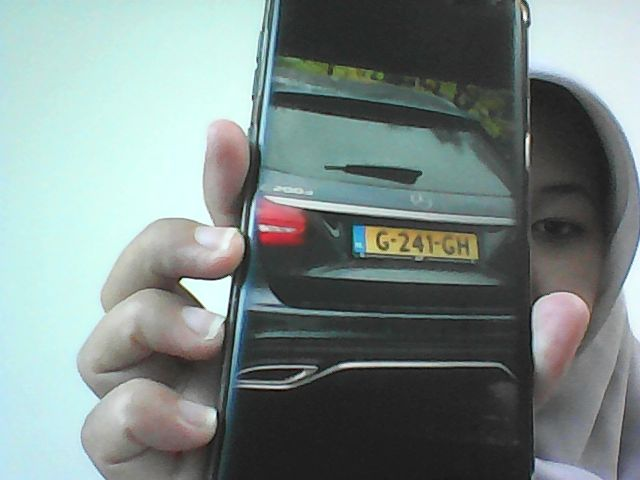

In [163]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


0: 480x640 1 License_Plate, 1644.9ms
Speed: 2.6ms preprocess, 1644.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


License Plate:G241GH


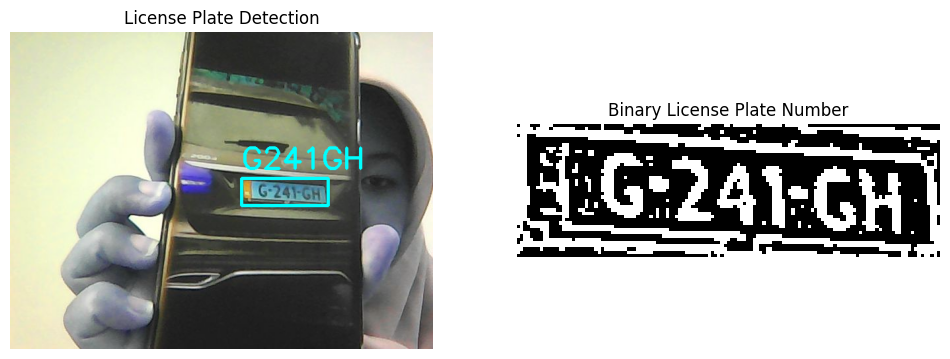

In [167]:
license_plate_detector(filename)

<IPython.core.display.Javascript object>

Saved to photo.jpg


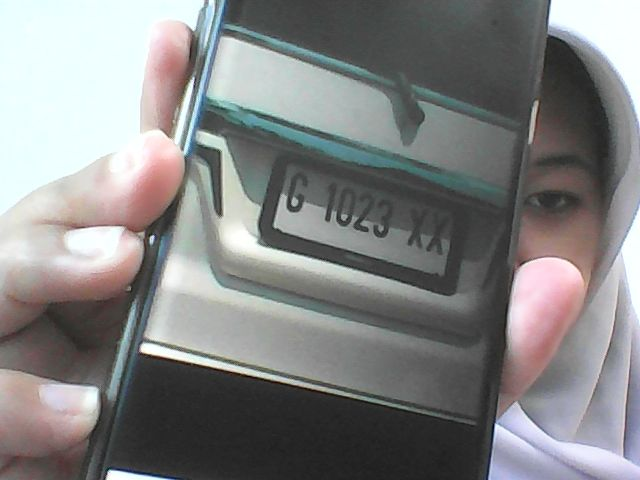

In [168]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


0: 480x640 1 License_Plate, 904.0ms
Speed: 2.8ms preprocess, 904.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


License Plate:74023


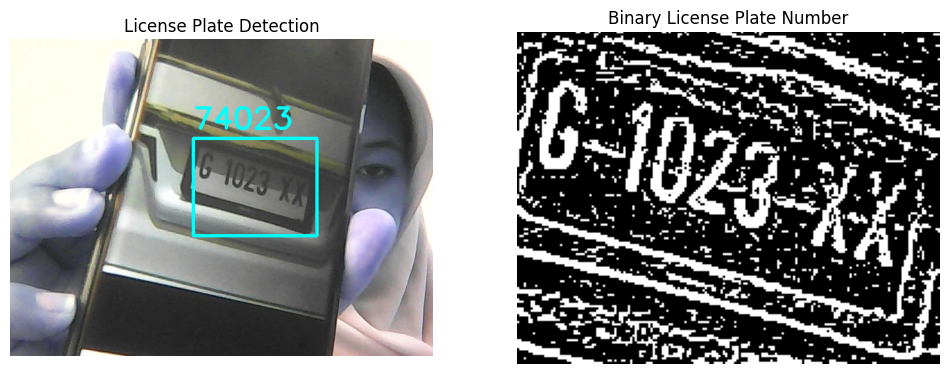

In [169]:
license_plate_detector(filename)